# About
This notebook performs all the analysis associated with surface chemical interactions seen in Figure 4 of the manuscript.

This notebook specifically executes all the FINCHES analysis, while the surface chemistry analysis is done by the `surface_chemistry.ipynb` notebook. 

This notebook requires the following specialized packages (in addition to numpy/scipt/matplotlib etc):

* [FINCHES](https://github.com/idptools/finches/) - package for predicting inter-protein chemical specificity
* [protfasta](https://protfasta.readthedocs.io/en/latest/installation.html) - package for reading and writing FASTA files
* [SHEPHARD](https://shephard.readthedocs.io/en/latest/index.html) - package for organizing large datasets of protein-centric data

In [1]:
import numpy as np
import matplotlib
import sys
import os

import itertools
import pickle

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
	
# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.5

# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

# UPDATE 2020-12-31 (my preferred font is Avenir...)
font = {'family' : 'arial',
    	'weight' : 'normal'}

matplotlib.rc('font', **font)


In [2]:
# lets you import from the code directory here
local_code_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'code'))

if local_code_path not in sys.path:
    sys.path.append(local_code_path)

In [3]:
from common_functions import annotate_with_quantiles

def normalize_array(arr):
    """
    Local function to define 
    """
    min_val = np.min(arr)
    max_val = np.max(arr)
    normalized_arr = (arr - min_val) / (max_val - min_val)
    return normalized_arr

REFERENCE_QUANTILES = [6, 18, 30, 42, 54, 66, 78, 90]

In [4]:
from shephard.interfaces import si_domains, si_protein_attributes, si_proteins
from shephard.apis import fasta
from shephard.tools import domain_tools
from shephard import Proteome

import protfasta

from finches import CALVADOS_frontend

cf = CALVADOS_frontend()

fingerprints = protfasta.read_fasta('../data/fingerprint_calvados_renamed.fasta')
# get the list of globular chemical interactions
globular_chemical_interactions = []
for k in fingerprints:
    globular_chemical_interactions.append(f'{k}_attractive')
    globular_chemical_interactions.append(f'{k}_repulsive')
globular_chemical_interactions.sort()

def cast_attributes(obj, include=[], exclude=[], cast_type=float):
    if len(include) > 0:
        for a in include:
            if a in obj.attributes:
                obj.add_attribute(a, cast_type(obj.attribute(a)), safe=False)
    if len(exclude) > 0:
        for a in obj.attributes:
            if a not in exclude:
                obj.add_attribute(a, cast_type(obj.attribute(a)), safe=False)
                


/Users/alex/Dropbox/WASHU/Holehouse/tools/finches/finches/finches/forcefields/calvados.py:235: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.038286503882254706' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  r.loc['H','q'] = 1. / ( 1 + 10**(self.pH-6) )


In [5]:
# load up the proteome of soluble proteins
yp = Proteome()

mode_selector = 'dodo'

if mode_selector == 'dodo':
    domain_file = 'shprd_dodo_domains_0.4.tsv'
    domain_mode = 'dodo'
    domain_name_def = 'globular_shprd'
elif mode_selector == 'chainsaw':
    domain_file = 'shprd_chainsaw_domains_0.4.tsv'
    domain_mode = 'chainsaw'
    domain_name_def = 'globular_chainsaw'
else:
    raise Exception('Invalid mode selector provided')




si_proteins.add_proteins_from_file(yp,'../data/experimental_data/shprd_proteome_soluble_only_v2.tsv')
si_domains.add_domain_attributes_from_file(yp, f'../data/shprd_files/{domain_file}',verbose=True)


domain_lengths_before_filter = []
for d in yp.domains:
    domain_lengths_before_filter.append(len(d))


# cast protein attributes 
for p in yp:
    cast_attributes(p, exclude=['lip_color', 'non_ref_score', 'refoldable', 'nonrefoldable', 'membrane_protein','non_ref','subcellular_localization'])

# cast domain attributes to floats
for d in yp.domains:
    if d.domain_type == domain_name_def:
        cast_attributes(d, exclude=['seq'])


fingerprints = d.attributes

domains_to_remove = []

# here we define some settings
min_size_threshold = 90
max_size_threshold = 1000
for d in yp.domains:
    if len(d) < min_size_threshold or len(d) > max_size_threshold:
        domains_to_remove.append(d)

for d in domains_to_remove:
    p = yp.protein(d.protein.unique_ID)
    p.remove_domain(d)

print(f"Number of domains identified: {len(yp.domains)}")
        


Number of domains identified: 3347


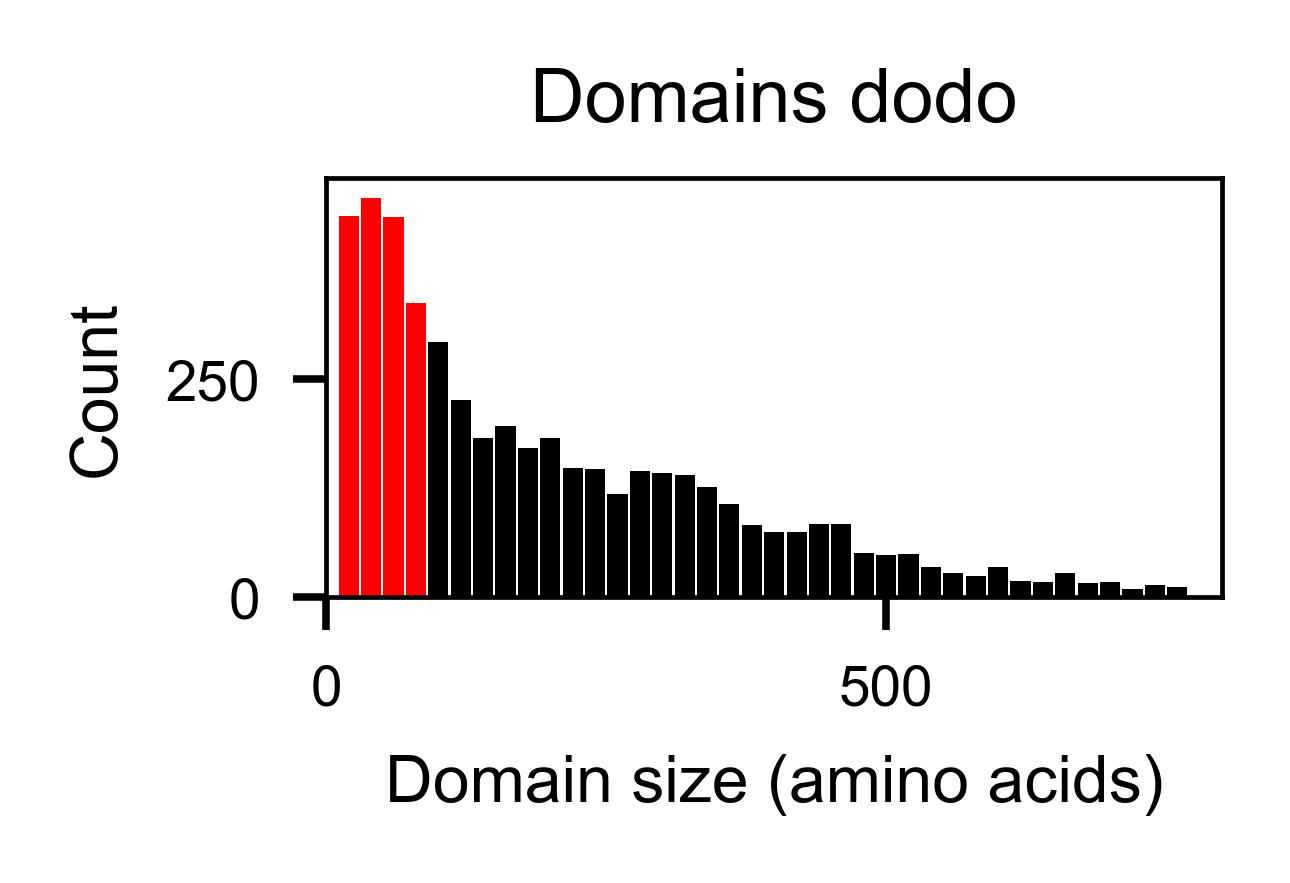

In [6]:
figure(None, (2,1.4), dpi=340)

ax = plt.gca()
bin_size=20
bins = np.arange(0,800,bin_size)
X = np.histogram(domain_lengths_before_filter, bins=bins)
plt.bar(X[1][:-1][0:5], X[0][0:5], width=bin_size*0.9, color='r')
plt.bar(X[1][:-1][5:], X[0][5:], width=bin_size*0.9, color='k')
plt.xlim([0,800])


plt.xlabel('Domain size (amino acids)',fontsize=7)
plt.ylabel('Count',fontsize=7)

plt.yticks(fontsize=6)
plt.xticks(fontsize=6)
plt.title(f'Domains {domain_mode}', fontsize=8)

plt.tight_layout()
plt.savefig(f'outfigures/{domain_mode}/domain_histo.pdf')



In [7]:
# important cell where we call the annotate_with_quantiles() function.
# This  takes the yeast proteome and based on the proteins with S/T annotationes 
# assigns each protein as a a quantile value. The default parameters are explicitly 
# defined here for clarity, so
#
# (1) we generate 8 quantiles and 
# (2) we are ONLY doing this for proteins with domains (i.e. if there are proteins with S/T mean annotations
#     but lack any domains, they are excluded

annotate_with_quantiles(yp, q=8, proteins_with_domains=True)    

# The output of this is every protein has a new "quantile" attribute added, which defines the quantile
# the protein falls into

Sanity check number of proteins in each group
[334, 334, 334, 333, 333, 333, 333, 333]


[6, 18, 30, 42, 54, 66, 78, 90]

In [8]:
c=0
for p in yp:
    if len(p.domains) > 0:
        c = c + 1    
print(f"Number of proteins with one or more domain {c}")
c=0
for p in yp:    
    c = c + len(p.domains)    
print(f"Number of domains {c}")

Number of proteins with one or more domain 2667
Number of domains 3347


In [9]:
# Write out proteins with quantile annotations and S_over_T_mean scores
with open(f'outdata/{domain_mode}/filtered_proteins_quantile.csv','w') as fh:
    quant2name = {}    
    for p in yp:
        if len(p.domains) > 0:
            q = p.attribute('quantile')
            if q not in quant2name:
                quant2name[q] = []
            quant2name[q].append([p.name, len(p.domains), p.attribute('S_over_T_mean')])

    for q in REFERENCE_QUANTILES:
        tmp = quant2name[q]
        
        tmp = sorted(tmp, key=lambda x: x[2])
        quant2name[q] = tmp

    idx = 0
    fh.write(f'index, quantile, uniprot, number of domains, S over T mean\n')
    for q in REFERENCE_QUANTILES:
        for p in quant2name[q]:
            fh.write(f'{idx}, {q}, {p[0]}, {p[1]}, {p[2]}\n')

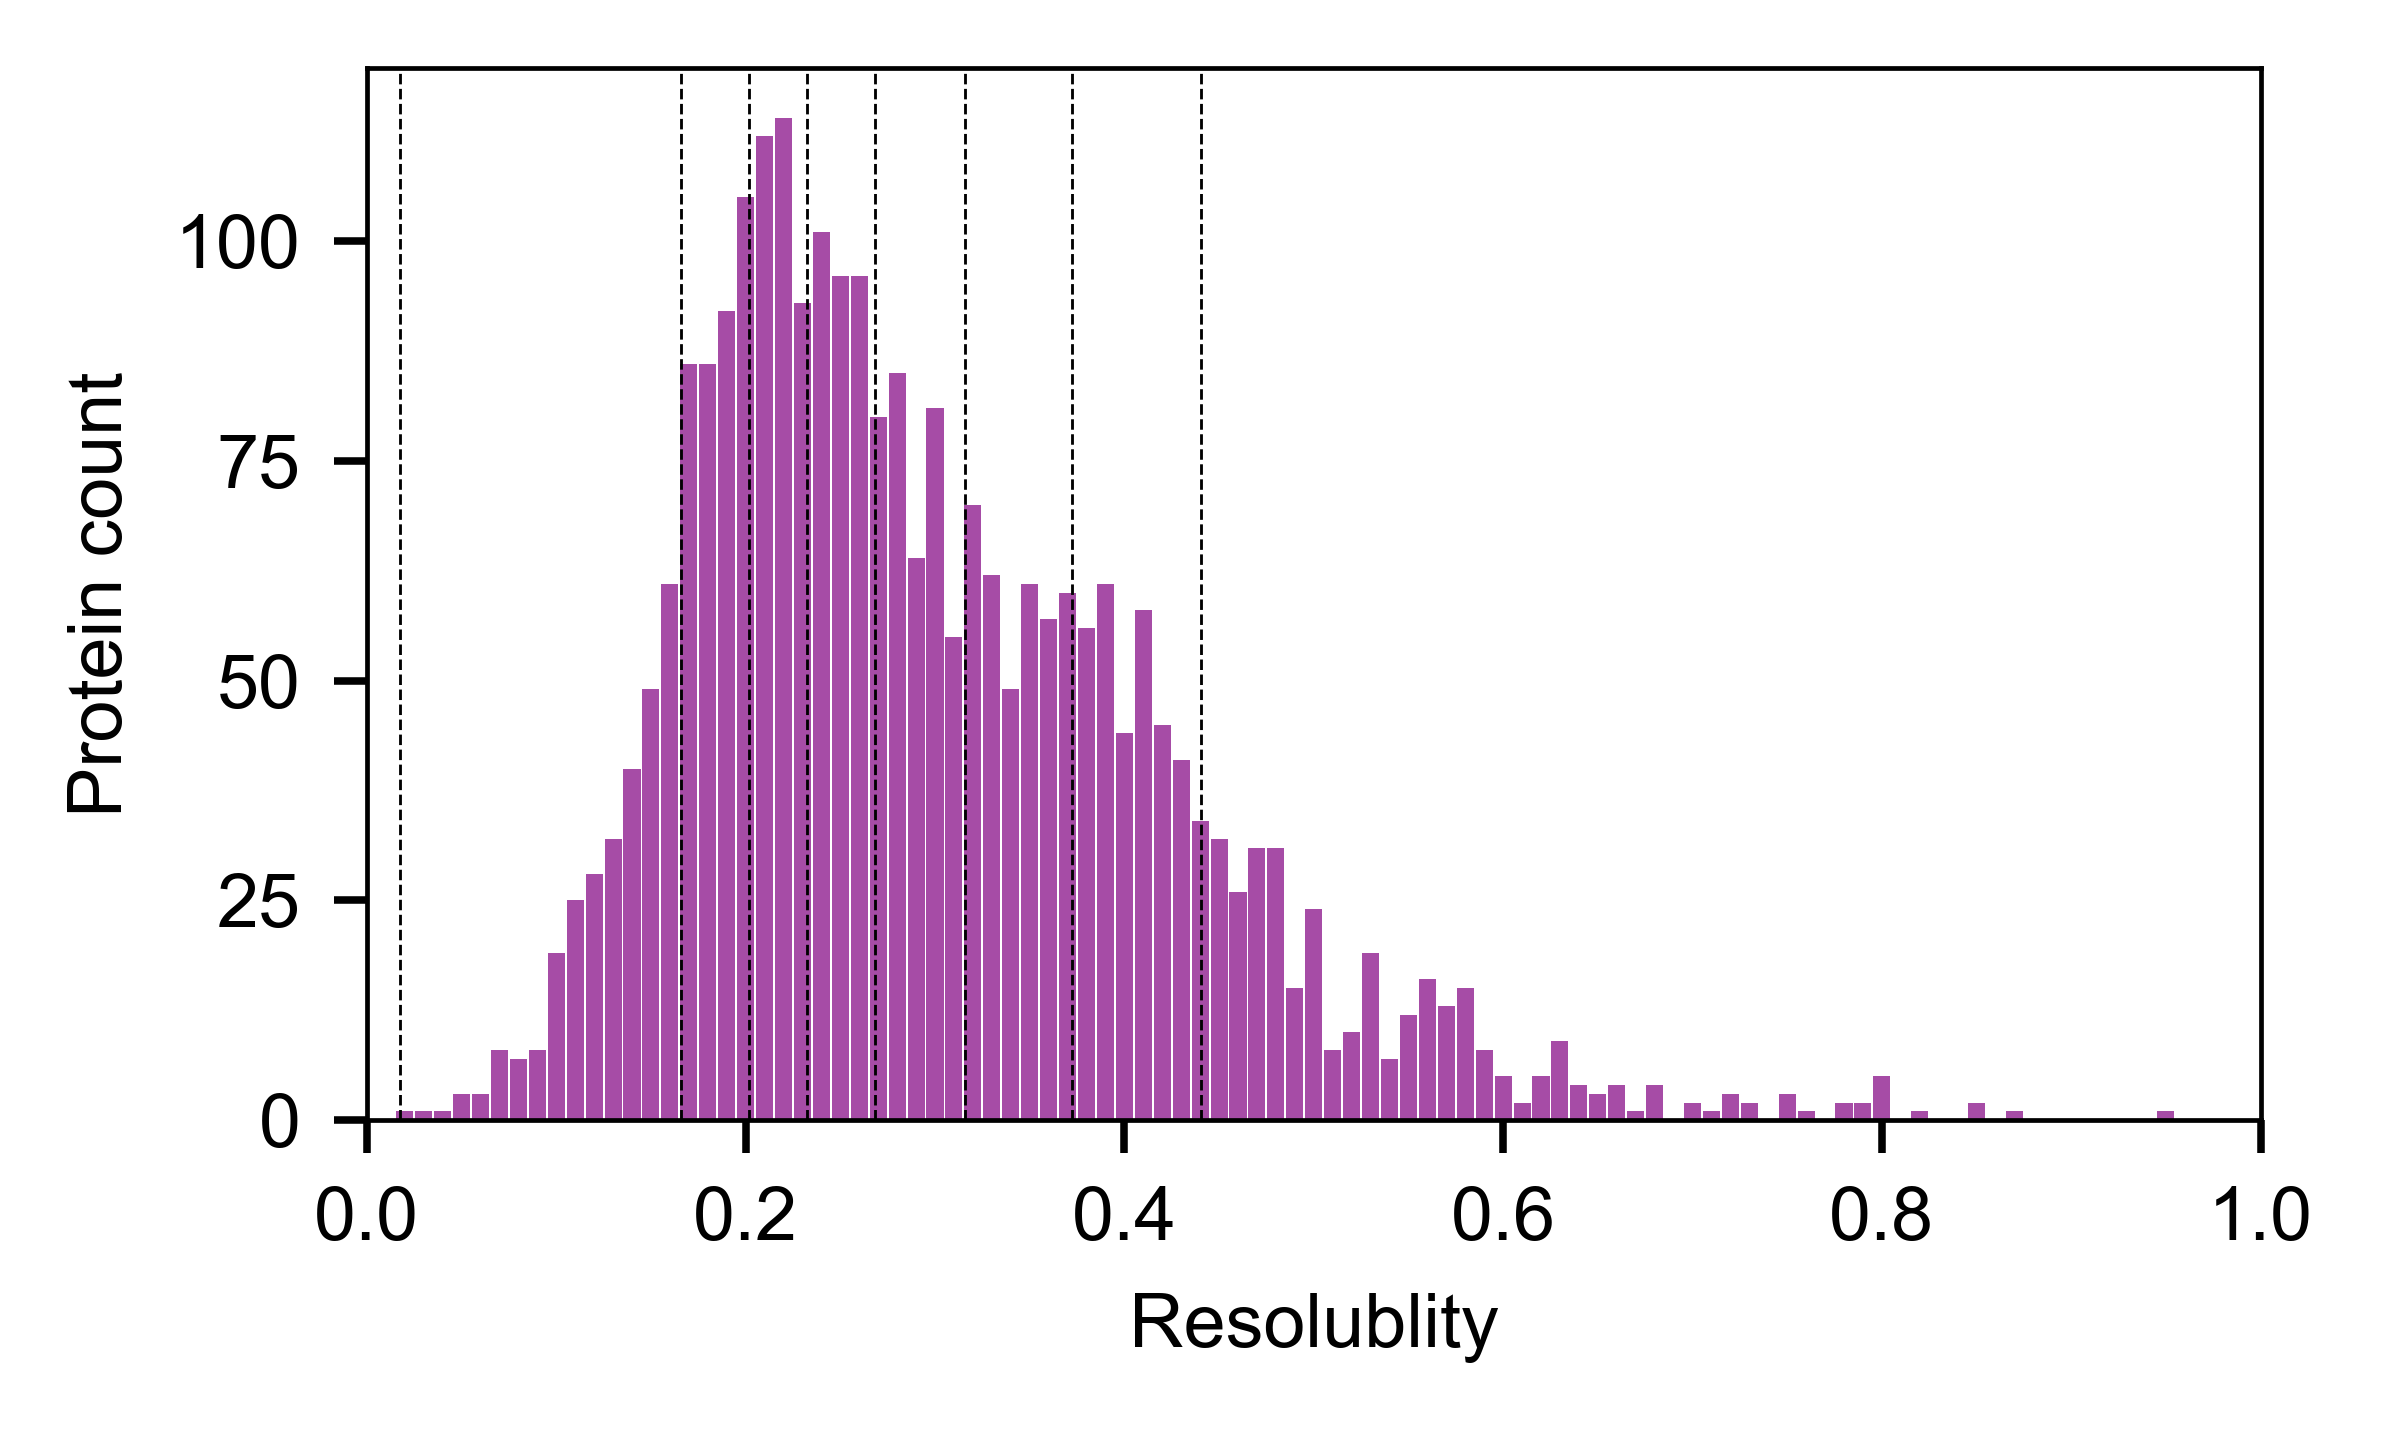

In [10]:
# write out histogram of proteins with S over T vs. count and dashed
# lines showing the boundaries of the different quantiles.
quant_boundaries = {}
all_s_t_vals = []
for q in REFERENCE_QUANTILES:
    quant_boundaries[q] = np.min([x[2] for x in quant2name[q]])
    all_s_t_vals.extend([x[2] for x in quant2name[q]])
bw = 0.01
bins = np.arange(0,3,bw)
[a,b] = np.histogram(all_s_t_vals, bins)    

figure(None, (3.6,2.2), dpi=340)
ax = plt.gca()
plt.bar(b[1:],a,width=bw*0.9,color='purple',alpha=0.7)
plt.xlim([0,1])
for q in quant_boundaries:
    ax.axvline(quant_boundaries[q], lw=0.3, color='k',ls='--')

plt.ylabel('Protein count', fontsize=8)
plt.xlabel('Resolublity',fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.savefig(f'outfigures/{domain_mode}/{domain_mode}_S_over_t_histogram.pdf')

    

## Precompute fingerprint vs. S_over_T values
The cell below organizes the (precomputed) surface residue:fingerprint attractive and repulsive interactions and correlates them 

In [11]:
chem2cor = {}
chem2scores = {}

# NOTE we actually use median here
chem2mean_scores = {}

# for each chemical fingerprint
for k in fingerprints:

    # define empty dictionaries
    scores = {}
    chem_string = '' 

    # for each domain in the proteome
    for d in yp.domains:

        # get the quantile of the protein associated with this domain
        q = d.protein.attribute('quantile')
        if q not in scores:
            scores[q] = []

        # map the epislon value for domain surface : this dipeptide
        # to the quantile associated with this protein
        scores[q].append(d.attribute(k))

    # sort the dictionary so that the order of keys is from smallest to largest quantile
    scores = dict(sorted(scores.items(), key=lambda item: item[0], reverse=False))
    mean_scores = []

    # define quantile keys
    x_iles = list(scores)

    # calculate median chemical score for all interactions associated with the s-th quantile
    for s in x_iles:
        mean_scores.append(np.median(scores[s]))

    # calculate correlation between quantiles and average chemical scores
    chem2cor[k] = np.corrcoef(mean_scores, x_iles)[0][1]

    # get all scores as a nested table 
    chem2scores[k] = list(scores.values())

    # get average scores 
    chem2mean_scores[k] = mean_scores

/Users/alex/miniconda3/envs/neuron39/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/alex/miniconda3/envs/neuron39/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


## Explanation of the data generated by the cell above
`chem2scores` is a dictionary that maps each dipeptide name (i.e. XX_attractive and XX_repulsive) to a nested list, which is itself the  complete set of domain:surface fingerprints. i.e.:

* `chem2scores['<dipeptide_name>'][0]` = list of fingerprint:surface values for all domains associated with proteins in the lowest %ile
* `chem2scores['<dipeptide_name>'][...]` = list of fingerprint:surface values for all domains associated with each %ile
* `chem2scores['<dipeptide_name>'][-1]` = list of fingerprint:surface values for all domains associated with proteins in the highes %ile

`chem2mean_scores` is a dictionary that maps each dipeptide name (i.e. XX_attractive and XX_repulsive) to a list of average interaction scores associated with that dipeptide and domains associated with proteins in the x-th quantile, i.e.

* `chem2mean_scores['<dipeptide_name>'][0]` = Average value for all domains associated with proteins in the lowest %ile
* `chem2mean_scores['<dipeptide_name>'][...]` = Average value for all domains associated with each %ile
* `chem2mean_scores['<dipeptide_name>'][-1]` = Average value for all domains associated with proteins in the highes %ile

and finally:

`chem2cor` is a dictionary that maps each dipeptide name (i.e. XX_attractive and XX_repulsive) to the correlation between quantile and that that chemistrie's interaction




In [12]:
print('Example showing average scores between each %ile and the DE_attractive dipeptide')
print(chem2mean_scores['DE_attractive'])

Example showing average scores between each %ile and the DE_attractive dipeptide
[-25.39, -22.751, -23.1445, -22.5465, -20.989, -19.308, -18.166, -16.2155]


In [13]:
# save those mappings
with open(f'outdata/{domain_mode}/{domain_mode}_correlation_data.pickle', 'wb') as file:
    pickle.dump(chem2cor, file)


## Plot correlations of quantile vs. chemical interaction
We generate this plot basically to motivate the fact that for SOME chemistries there is a clear and pretty monotonic relationship between quantile and average chemical interaction (correlation coefficients here are very high at >0.9, but visual inspection of these plots is, IMO, a more useful way to convince yourself this is an acceptable relationship to explore further).

In [14]:
# plot correlation 
for name in fingerprints:
    color='r'
    figure(None, (1.3,2.2), dpi=340)
    boxprops = dict(linewidth=3,alpha=0.6, color='k')
    
    plt.plot(x_iles, chem2mean_scores[name],color='w')
    
    all_s = []
    for idx, s in enumerate(chem2scores[name]):
        pos = x_iles[idx]
        scatter_pos = np.random.randn(len(s))*1.1+pos
        plt.scatter(scatter_pos, s, s=4, alpha=0.08, c=color,linewidth=0)
    
        b = plt.boxplot(s, positions=[pos],widths=[0.6],showfliers=False, whis=0, boxprops=boxprops,medianprops=boxprops, )
        all_s.extend(s)
    
    all_s = sorted(all_s)
    
    yoff_idx = int(len(all_s)*0.02)
    ymin = all_s[yoff_idx]
    ymax = all_s[len(all_s)-yoff_idx]
    
    plt.plot(x_iles, chem2mean_scores[name],'o',color='w', zorder=20,ms=3)
    plt.ylim([ymin,ymax])
    
    plt.title(f"{name}", fontsize=8)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.tight_layout()
    
    plt.savefig(f'outfigures/{domain_mode}/0_4/{name}.pdf')
    plt.close()
    
    
    

/var/folders/2n/xtzsyspd32v6vglg_pd5gmw80000gn/T/ipykernel_4427/667651303.py:25: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim([ymin,ymax])


# Heatmap section


### Set parameters
Because there are some differences between the different domain decomposition approaches we define specific parameters here

In [15]:
params={}
params['chainsaw'] = {}
params['dodo'] = {}

params['chainsaw']['attractive_derivative'] = 0.5
params['chainsaw']['repulsive_derivative'] = -0.5
params['chainsaw']['y-barlim'] = 12

params['dodo']['attractive_derivative'] = 0.5
params['dodo']['repulsive_derivative'] = -0.5
params['dodo']['y-barlim'] = 12

The cells below enable us to construct heatmaps using normalized interaction scores.

In [16]:
# This first cell generates the max_change_attractive_weakened and max_change_attractive_strengthend dictionaries. 
# These dictionaries report on the max-min in chemical interaction space between the average folded domain surface
# to fingerprint peptide, effectively asking "which types of interactions change a lot across the different quantiles"
#

# first get all the attractive and repulsive naes names
attractive_names = []
repulsive_names  = []
for name in fingerprints:
    if name.find('attractive') > -1:
        attractive_names.append(name)
    elif name.find('repulsive') > -1:
        repulsive_names.append(name)
    else:
        print('ERROR')

# <><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>

# next we're going to define 
max_change_attractive_weakened = {}
max_change_attractive_strengthened = {}
all_attractive_linear_fit_gradients = []


# and then for each of the attractive names...
for n in attractive_names:

    # get the max and min values associated with the mean chemical interactions for that
    # attractive chemistry with each of the quantiles...
    minval = np.min(chem2mean_scores[n])
    maxval = np.max(chem2mean_scores[n])

    # finally we segretate the into "weakening" and "strengthening"...
    
    # do this to find those where we see a positive correlation between chemical interactoin
    # and quantile. This is a kind of simple hack just to find datasets where attractive interaction
    # become WEAKER as we go to higher percentile >large positive correlation or smaller. Note that
    # the term "strengthened" here is super misleading - these other interactions aren't necessarily
    # becoming stronger, their just not becoming obviously weaker (obviously here requiring a positive
    # derivative of 0.6 (units here = interaction energy units). The 0.6 here is empirically defined and
    # gives us a way to codify the chemistries that are getting weaker 

    fit_derivative = np.polyfit(np.arange(1,9), chem2mean_scores[n],1)[0]
    all_attractive_linear_fit_gradients.append(fit_derivative)
    if fit_derivative > params[domain_mode]['attractive_derivative']:
        max_change_attractive_weakened[n] = maxval - minval 
    else:
        max_change_attractive_strengthened[n] = maxval - minval 


combined = sorted(zip(all_attractive_linear_fit_gradients, attractive_names.copy())) 
all_attractive_linear_fit_gradients, attractive_names_derivative_order = zip(*combined)

# <><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>

# we then repeat all of the above but now with the repulsive interactions

max_change_repulsive_weakened = {}
max_change_repulsive_strengthened = {}
all_repulsive_linear_fit_gradients = []

for n in repulsive_names:
    minval = np.min(chem2mean_scores[n])
    maxval = np.max(chem2mean_scores[n])

    # again using linear fit we find those things where repulsive interactions become weaker. 
    # NOTE the magnitude of the repulsive interactions is smaller so we use a much l

    fit_derivative = np.polyfit(np.arange(1,9),chem2mean_scores[n],1)[0]
    all_repulsive_linear_fit_gradients.append(fit_derivative)
    if  fit_derivative < params[domain_mode]['repulsive_derivative']:
        max_change_repulsive_strengthened[n] = maxval - minval 
    else:
        max_change_repulsive_weakened[n] = maxval - minval 
    

combined = sorted(zip(all_repulsive_linear_fit_gradients, repulsive_names.copy())) 
all_repulsive_linear_fit_gradients, repulsive_names_derivative_order = zip(*combined)


In [17]:
# rebuild these dictionaries ordered from largest to smallest in terms of change in interaction strength
max_change_attractive_weakened      = dict(sorted(max_change_attractive_weakened.items(),     key=lambda item: item[1],reverse=True))
max_change_attractive_strengthened  = dict(sorted(max_change_attractive_strengthened.items(), key=lambda item: item[1],reverse=True))

max_change_repulsive_weakened      = dict(sorted(max_change_repulsive_weakened.items(),       key=lambda item: item[1],reverse=True))
max_change_repulsive_strengthened  = dict(sorted(max_change_repulsive_strengthened.items(),   key=lambda item: item[1],reverse=True))



In [18]:
# next we're going to calculate the NORMALIZED values for these changes in chemistry across quantiles. Normalization 
# is done "internally" to a specific chemistry, and is guarenteed to scale between 0 (smallest) and 1 (largest), meaning all 
# values can be plotted on the same axes to visualize TRENDS (but in doing this we loose any information about the magnitudes),
# but that's ok because we will capture absolute values using the side bar charts

attractive_matrix_strengthed = []
attractive_matrix_names_strengthed = []
attractive_matrix_strengthed_raw = []

for name in max_change_attractive_strengthened:    
    attractive_matrix_strengthed.append(normalize_array(chem2mean_scores[name]))
    attractive_matrix_strengthed_raw.append(chem2mean_scores[name])
    attractive_matrix_names_strengthed.append(name.split('_')[0])


attractive_matrix_weakened = []
attractive_matrix_weakened_raw = []
attractive_matrix_names_weakened = []

for name in max_change_attractive_weakened:    
    attractive_matrix_weakened.append(normalize_array(chem2mean_scores[name]))
    attractive_matrix_weakened_raw.append(chem2mean_scores[name])
    attractive_matrix_names_weakened.append(name.split('_')[0])


# <><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>

# repeat all this for the repulsive matrices
repulsive_matrix_strengthed = []
repulsive_matrix_names_strengthed = []
repulsive_matrix_strengthed_raw = []

for name in max_change_repulsive_strengthened:
    repulsive_matrix_strengthed.append(normalize_array(chem2mean_scores[name]))
    repulsive_matrix_strengthed_raw.append(chem2mean_scores[name])
    repulsive_matrix_names_strengthed.append(name.split('_')[0])


repulsive_matrix_weakened = []
repulsive_matrix_names_weakened = []
repulsive_matrix_weakened_raw = []

for name in max_change_repulsive_weakened:
    repulsive_matrix_weakened.append(normalize_array(chem2mean_scores[name]))
    repulsive_matrix_weakened_raw.append(chem2mean_scores[name])
    repulsive_matrix_names_weakened.append(name.split('_')[0])

    

# we don't use the raw lists here any more,  but keep them for debugging etc.

/var/folders/2n/xtzsyspd32v6vglg_pd5gmw80000gn/T/ipykernel_4427/359662646.py:9: RuntimeWarning: invalid value encountered in divide
  normalized_arr = (arr - min_val) / (max_val - min_val)


# PLOT surface chemical trends

## First plot things for the attractive chemistries.

### Attractive chemistries weakening
The first pair of cells look at attratcive chemistries that become weaker from 0th to final quantile



Number of chemistries: 13


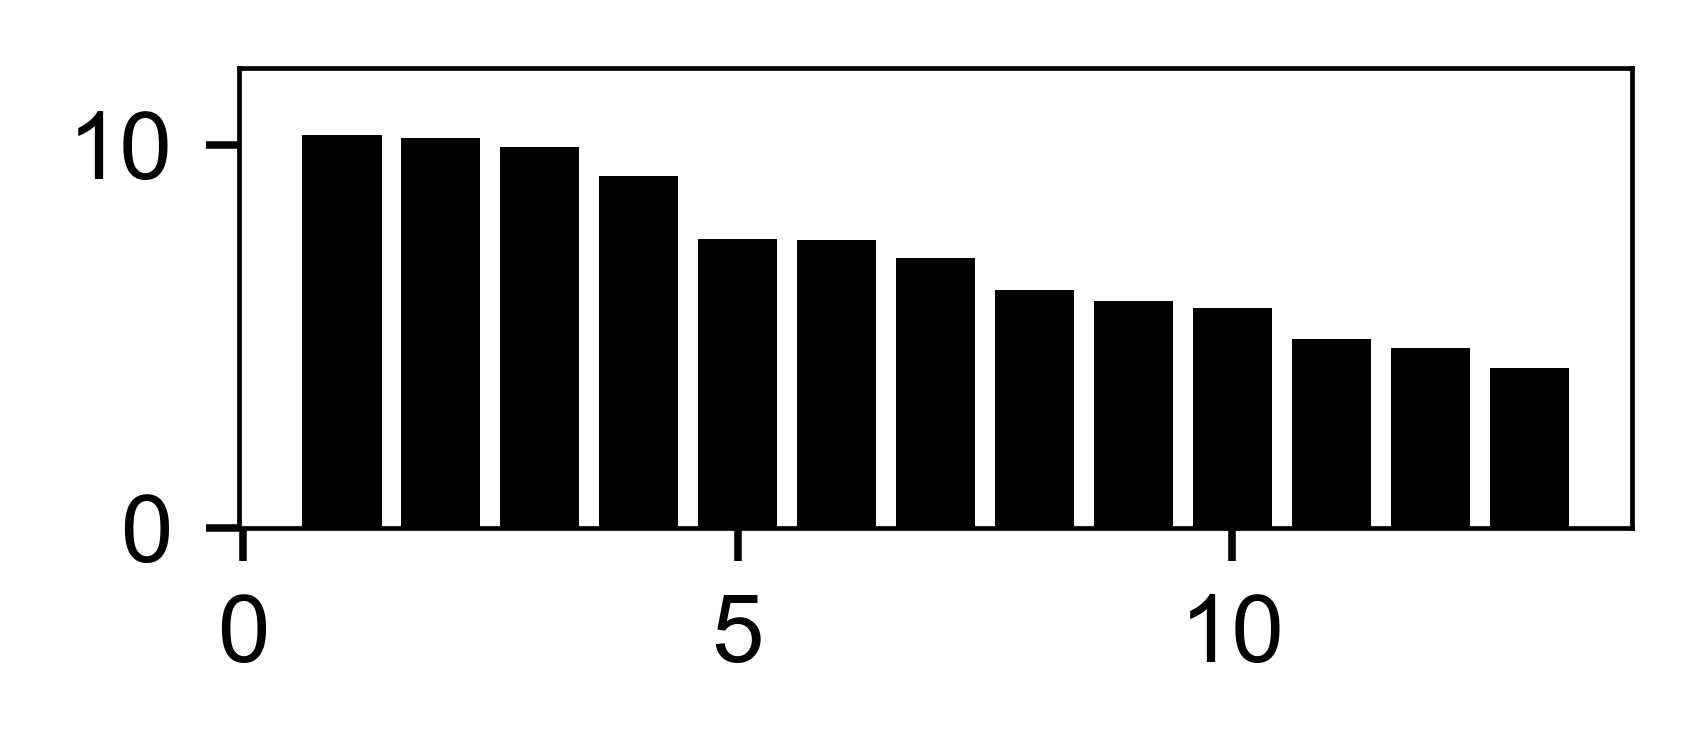

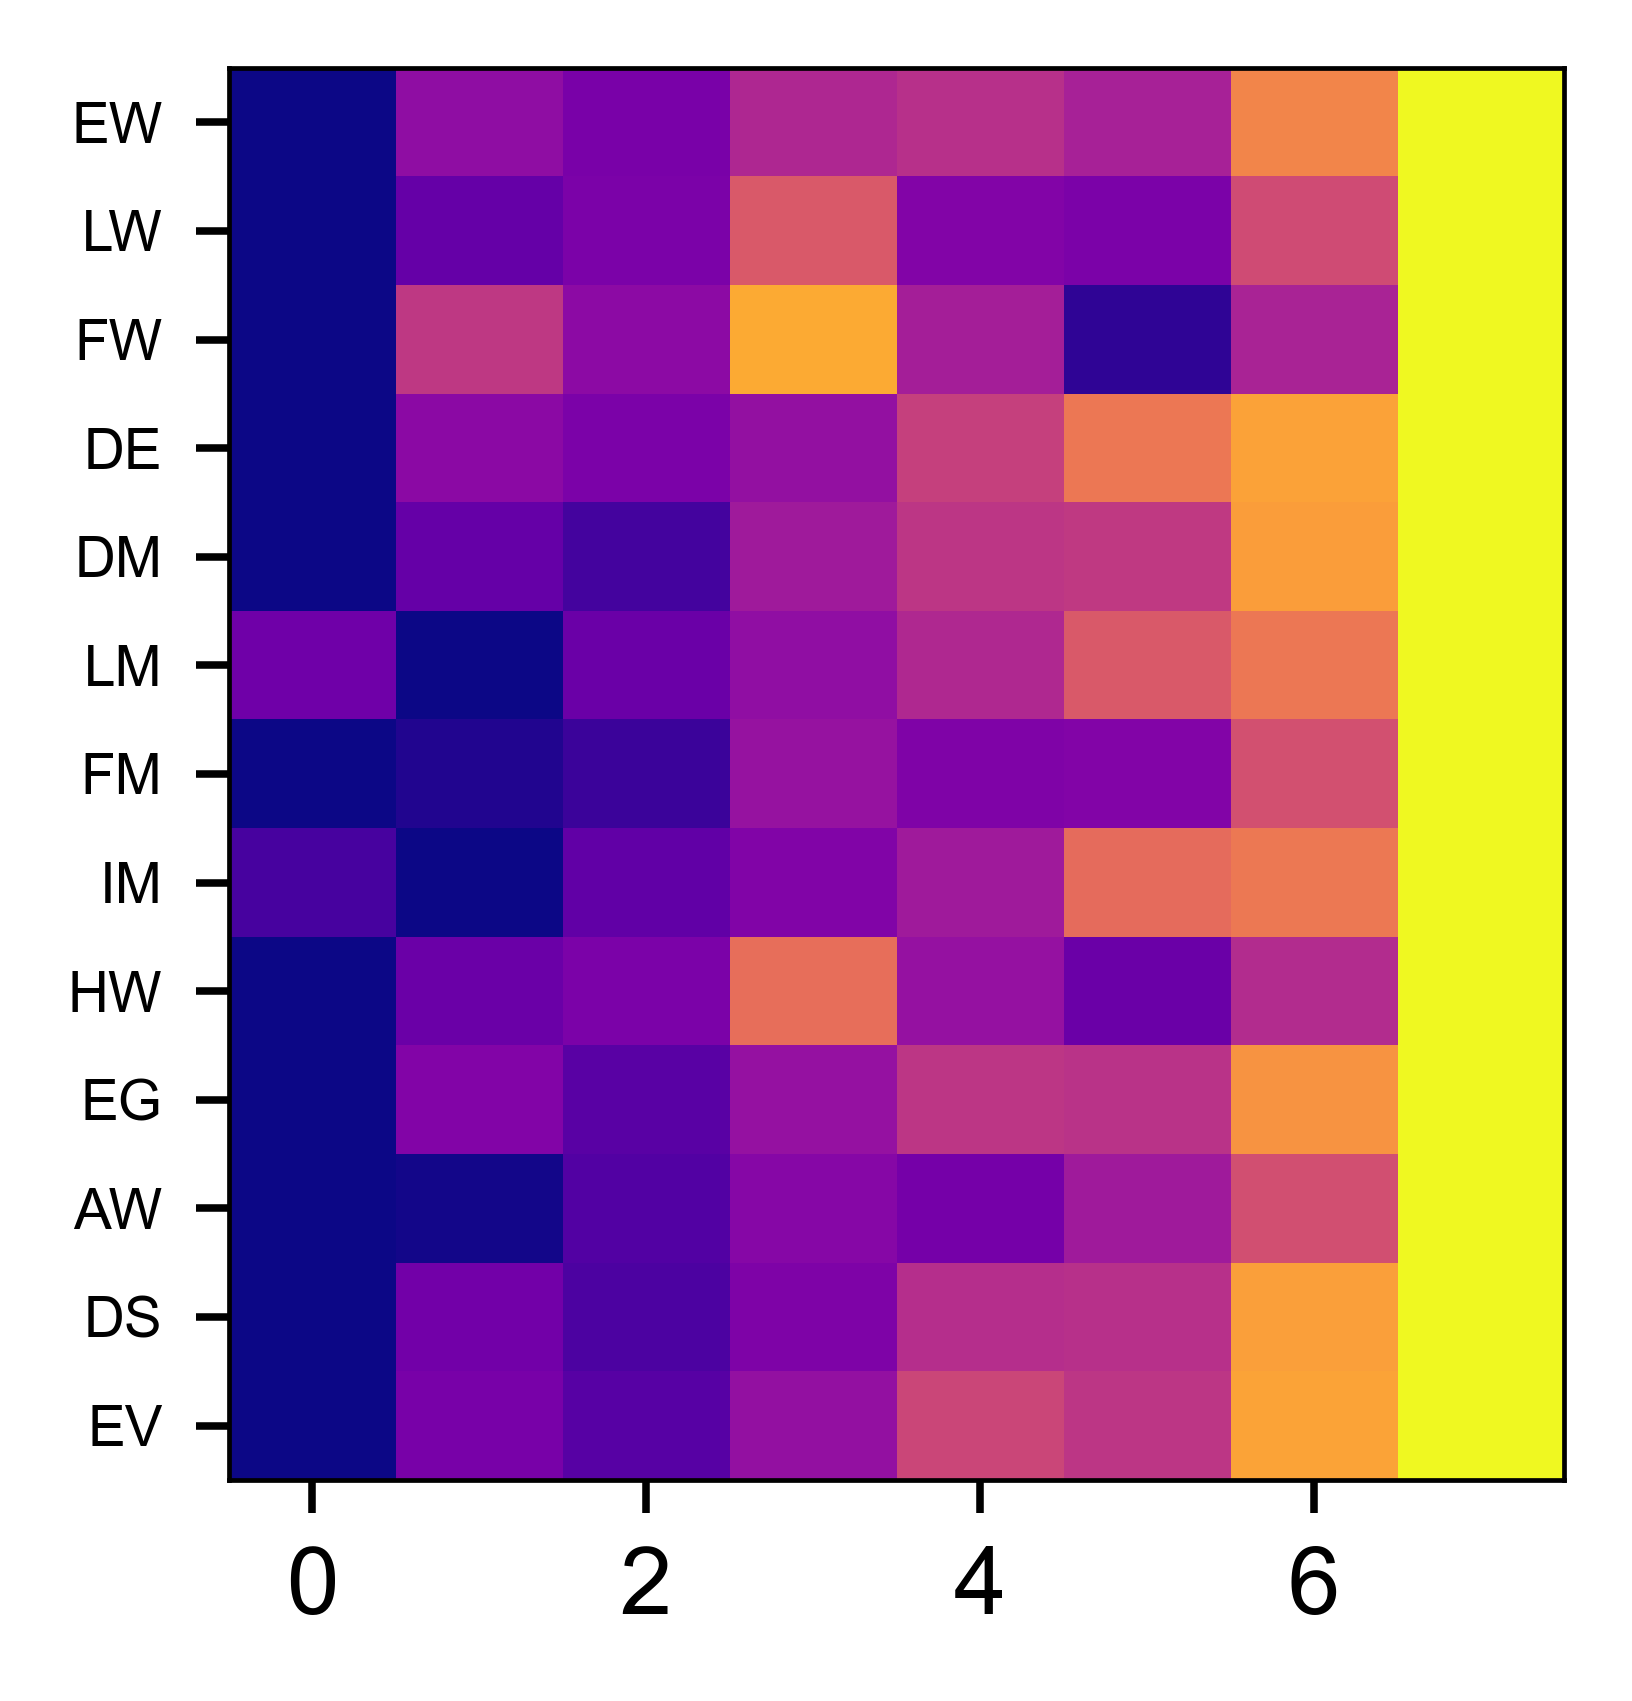

In [19]:
# this cell generates the bar chart which reports on the ABSOLUTE values in terms of how much things have changed
figure(None, (2.6,1.2), dpi=340)
local_vals = list(max_change_attractive_weakened.values())
local_idx  = np.arange(1, len(local_vals)+1)
plt.bar(local_idx, local_vals, color='k')

plt.ylim([0, params[domain_mode]['y-barlim']]) # define max so we have consist y axis for different chemistries 
plt.tight_layout()
plt.savefig(f'outfigures/{domain_mode}/{domain_mode}_attractive_weaken_interaction_magnitude.pdf')


# next we show this as a heatmap
figure(None, (2.5,2.6), dpi=340)
plt.imshow(np.array(attractive_matrix_weakened), cmap='plasma', aspect='auto', interpolation='None')        
plt.yticks(np.arange(0,len(attractive_matrix_names_weakened)),attractive_matrix_names_weakened, fontsize=6)
print('')
print(f"Number of chemistries: {len(attractive_matrix_names_weakened)}")

# uncomment this if you want to generate 
# plt.colorbar()
plt.tight_layout()
plt.savefig(f'outfigures/{domain_mode}/{domain_mode}_attractive_weaken.pdf')



### Attractive chemistries "not weakening" (stronger)...

Next we plot the ATTRACTIVE chemistries that don't become weaker ("stronger") as we from low to high quantile. Again, I want to remind myself that "stronger" in the variable names is convenient but wrong; selection here is for things that *didn't obviously become weaker*. Note these chemistries  


Number of chemistries: 23
NB: REMEMBER THAT 'STRENGTHENED' here == 'NOT WEAKENED'


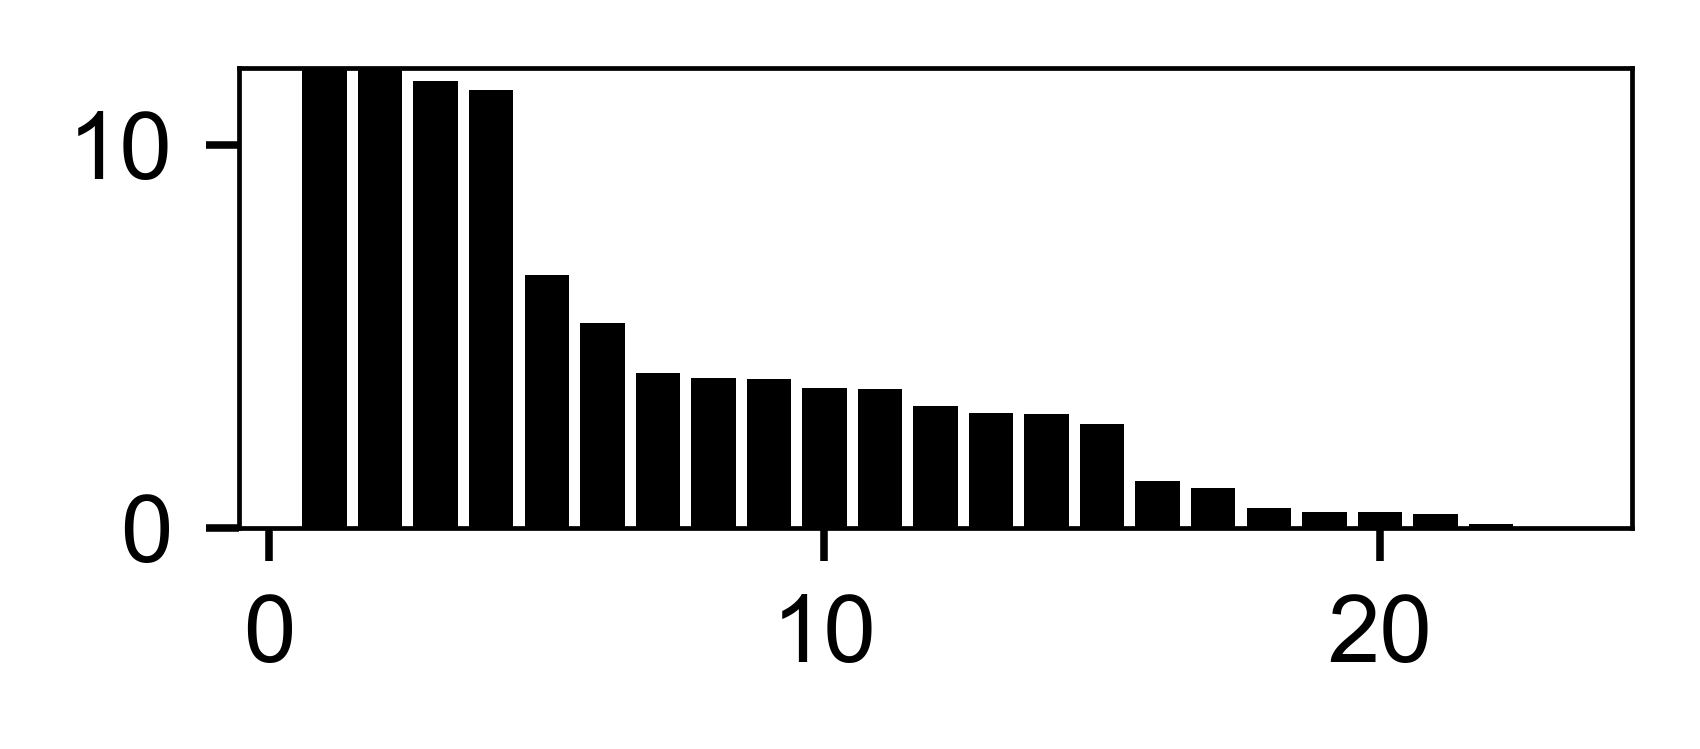

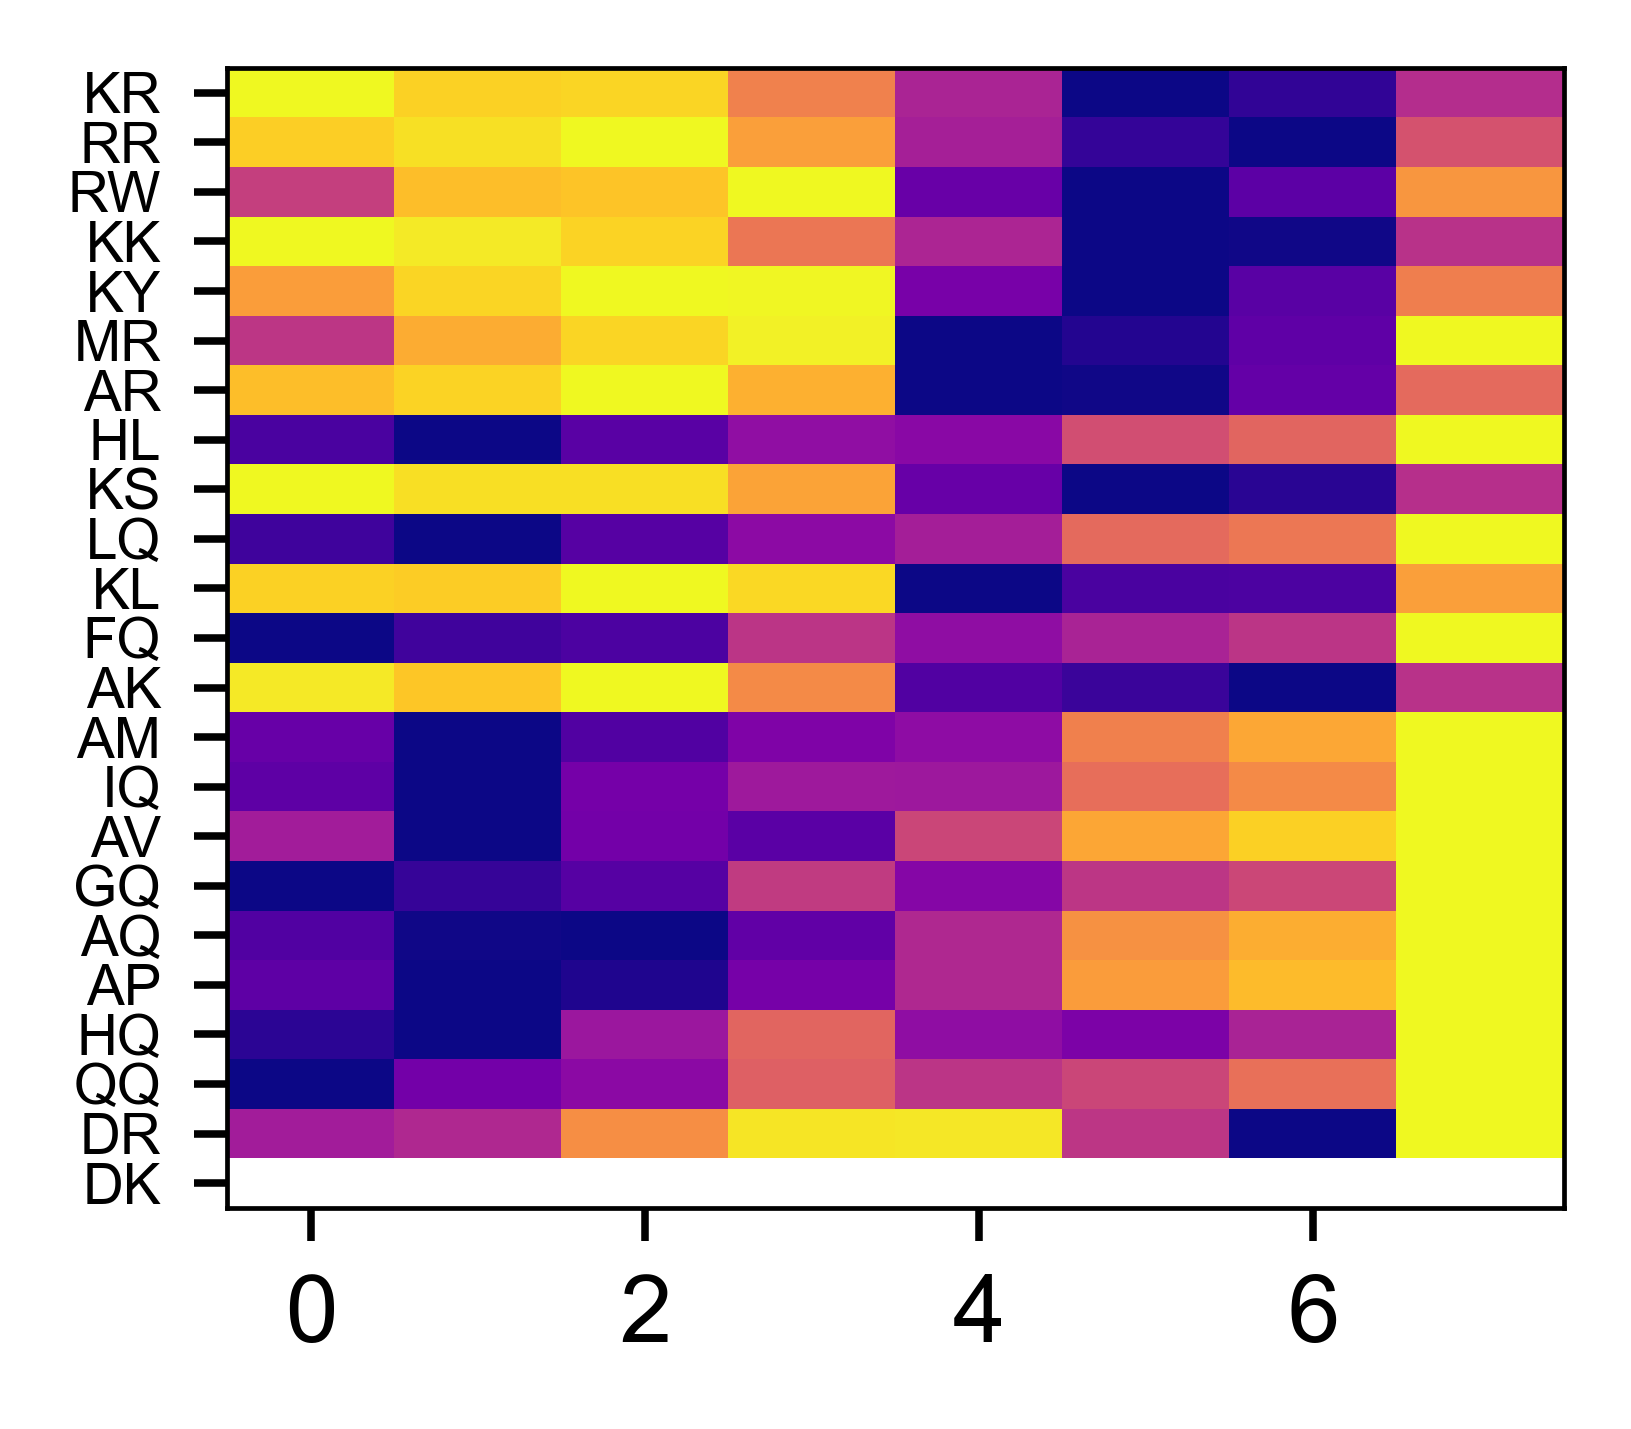

In [20]:
figure(None, (2.6,1.2), dpi=340)
local_vals = list(max_change_attractive_strengthened.values())
local_idx  = np.arange(1, len(local_vals)+1)
plt.bar(local_idx, local_vals, color='k')
plt.ylim([0, params[domain_mode]['y-barlim']]) # define max so we have consist y axis for different chemistries 
plt.tight_layout()
plt.savefig(f'outfigures/{domain_mode}/{domain_mode}_attractive_strengthen_interaction_magnitude.pdf')

figure(None, (2.5,2.2), dpi=340)

plt.imshow(np.array(attractive_matrix_strengthed), cmap='plasma', aspect='auto')        
plt.yticks(np.arange(0,len(attractive_matrix_names_strengthed)),attractive_matrix_names_strengthed, fontsize=6)
print('')
print(f"Number of chemistries: {len(attractive_matrix_names_strengthed)}")
#plt.colorbar()
plt.tight_layout()
plt.savefig(f'outfigures/{domain_mode}/{domain_mode}_attractive_strengthen.pdf')
print("NB: REMEMBER THAT 'STRENGTHENED' here == 'NOT WEAKENED'")

## Next plot things for the repulsive chemistries.

### Repulsive chemistries not strengthening ("weakening")
The first pair of cells look at attratcive chemistries that become "weaker" from 0th to final quantile. Again, 'weakening' here is wrong because basically none of these ACTUALLY become weaker, so, as the inverse of the attractive chemistries, these are the things that *don't become stronger*



Number of chemistries: 31
NB: REMEMBER THAT 'WEAKENING' here == 'NOT STRENGTHENING'


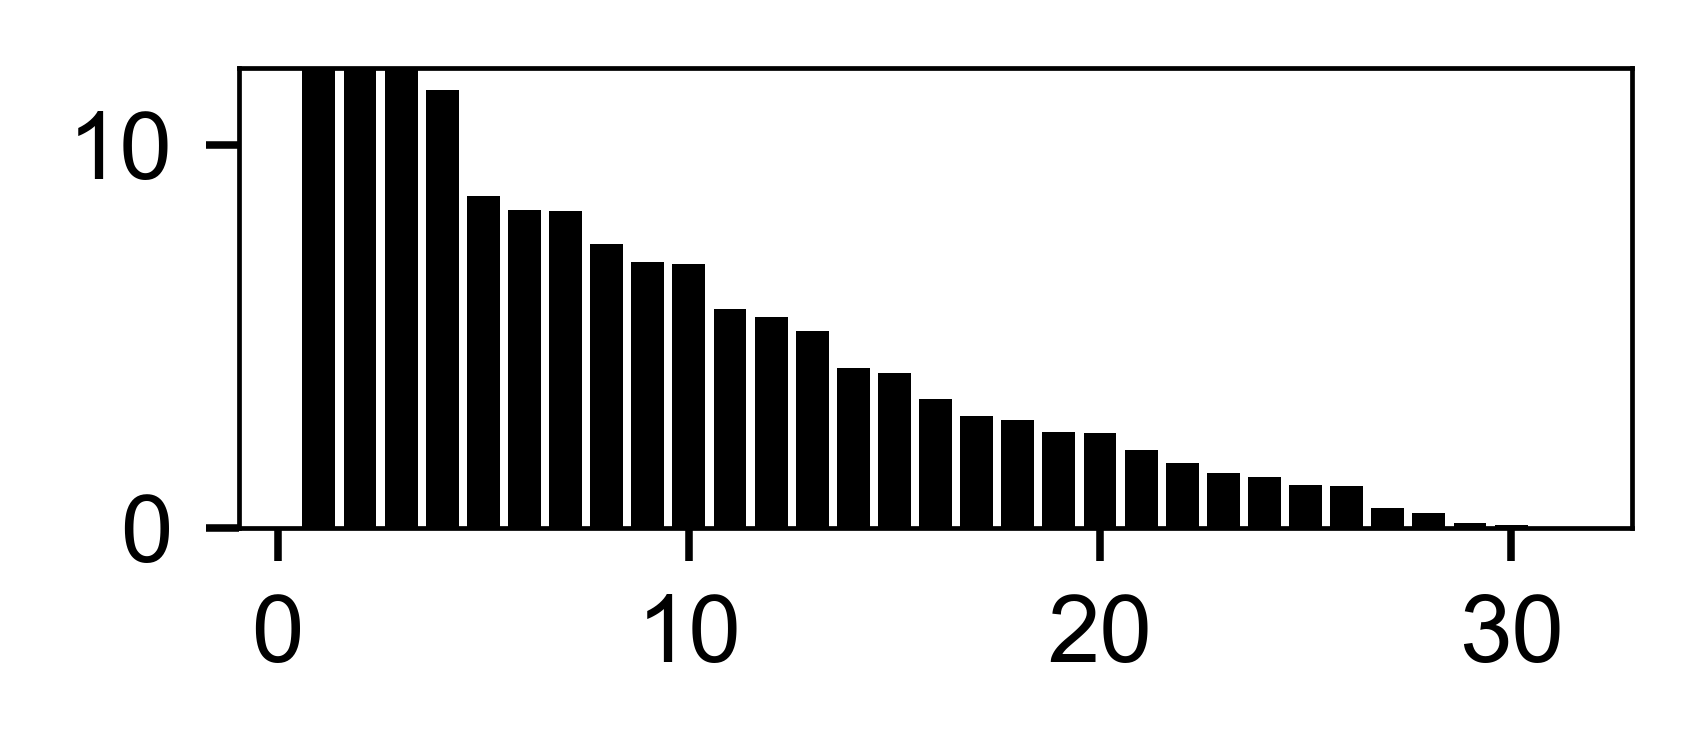

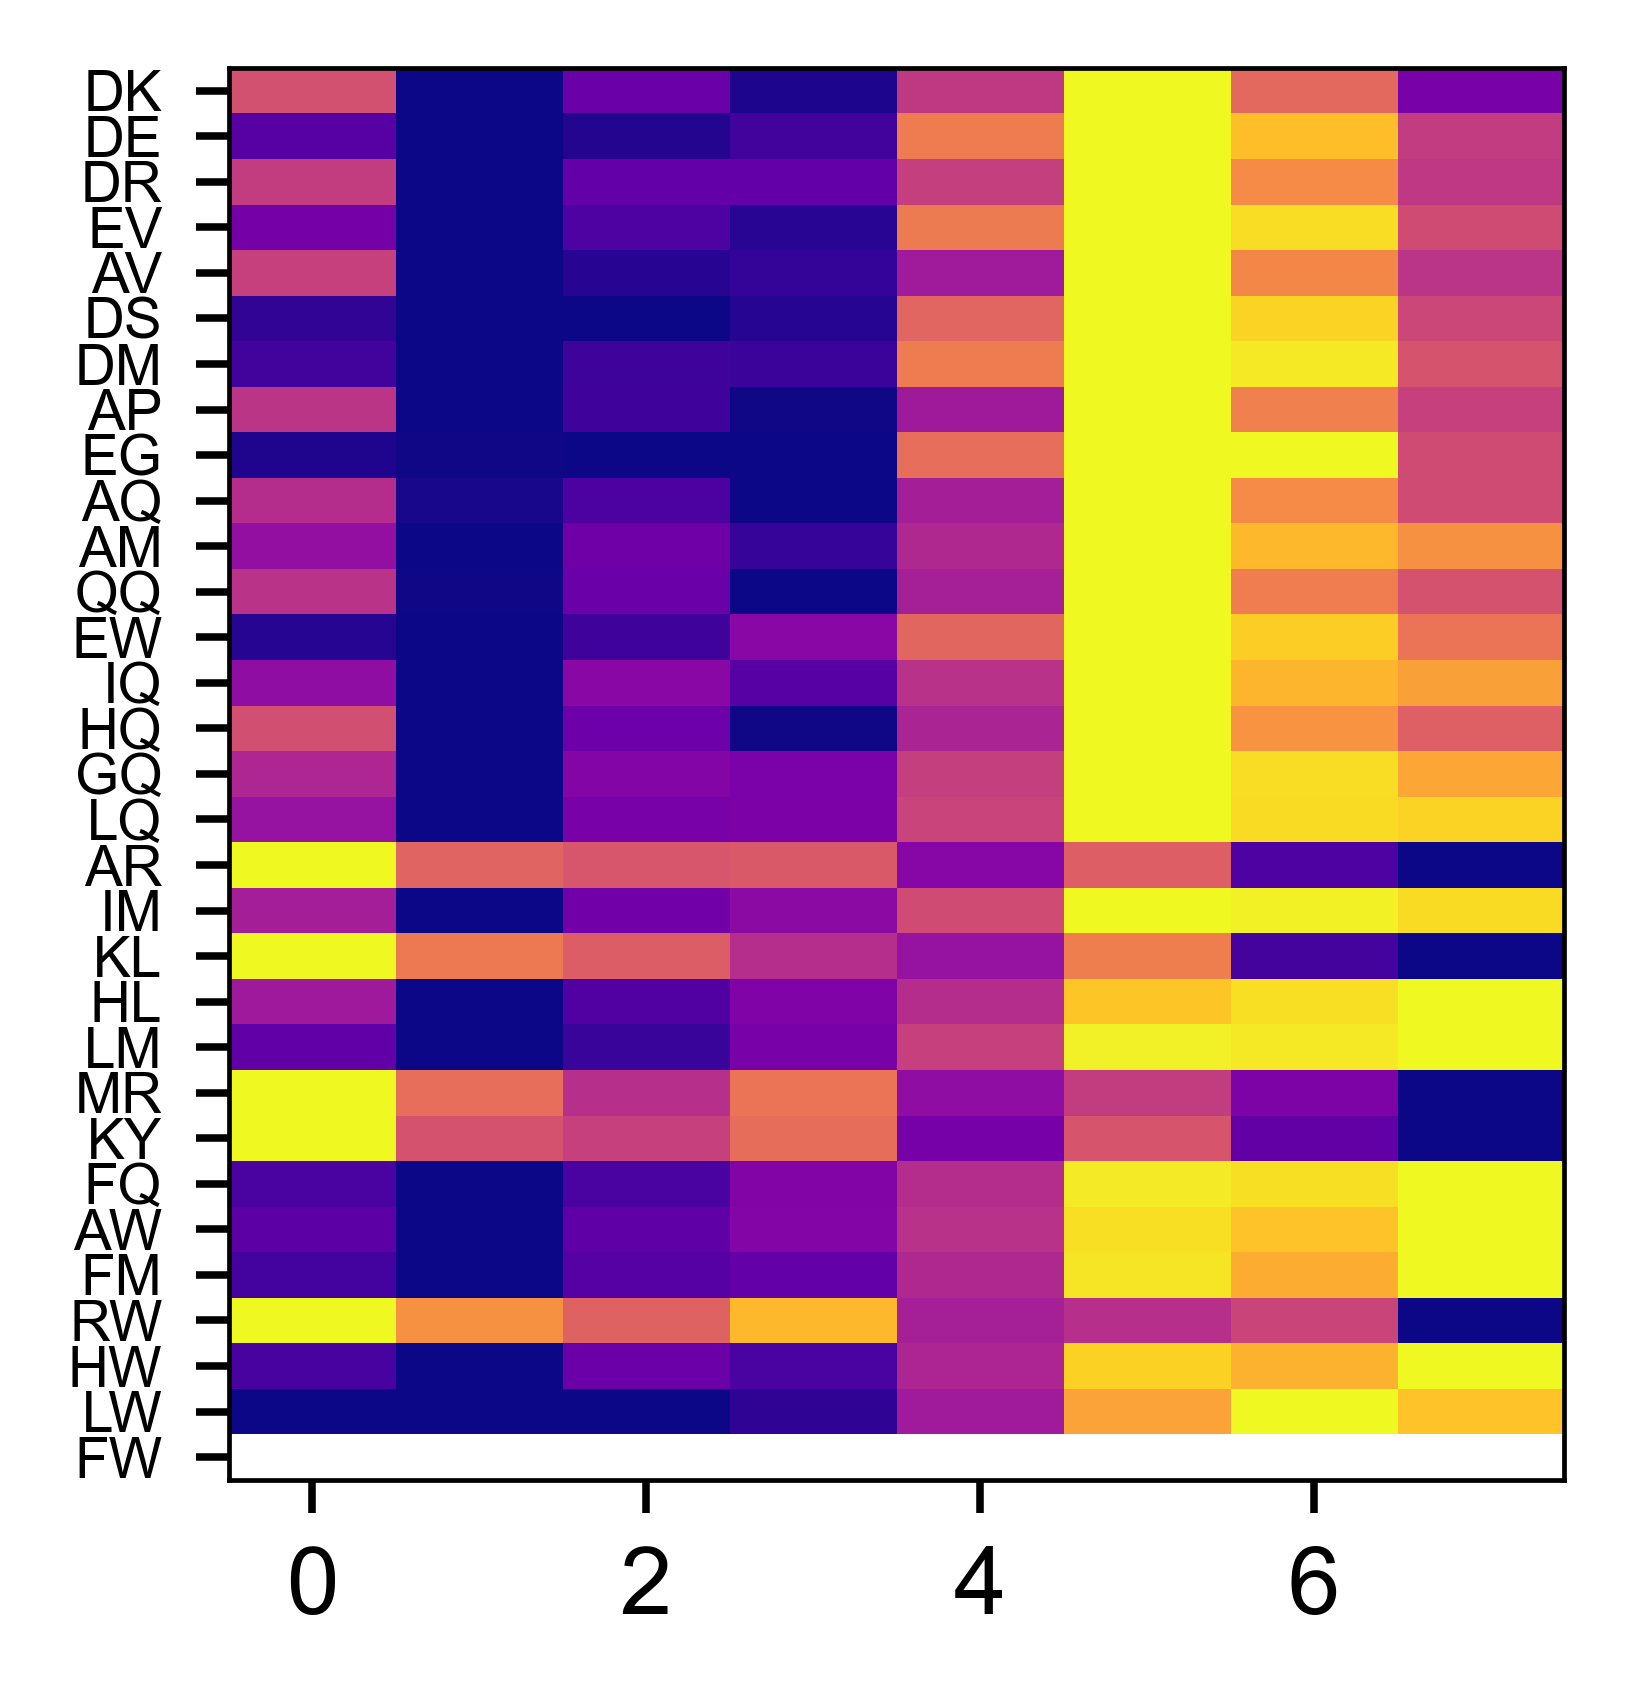

In [21]:
# this cell generates the bar chart which reports on the ABSOLUTE values in terms of how much things have changed
figure(None, (2.6,1.2), dpi=340)
local_vals = list(max_change_repulsive_weakened.values())
local_idx  = np.arange(1, len(local_vals)+1)
plt.bar(local_idx, local_vals, color='k')

plt.ylim([0, params[domain_mode]['y-barlim']]) # define max so we have consist y axis for different chemistries 
plt.tight_layout()
plt.savefig(f'outfigures/{domain_mode}/{domain_mode}_repulsive_weaken_interaction_magnitude.pdf')


# next we show this as a heatmap
figure(None, (2.5,2.6), dpi=340)
plt.imshow(np.array(repulsive_matrix_weakened), cmap='plasma', aspect='auto', interpolation='None')        
plt.yticks(np.arange(0,len(repulsive_matrix_names_weakened)), repulsive_matrix_names_weakened, fontsize=6)
print('')
print(f"Number of chemistries: {len(repulsive_matrix_names_weakened)}")

# uncomment this if you want to generate 
#plt.colorbar()
plt.tight_layout()
plt.savefig(f'outfigures/{domain_mode}/{domain_mode}_repulsive_weaken.pdf')
print("NB: REMEMBER THAT 'WEAKENING' here == 'NOT STRENGTHENING'")


### Repulsive chemistries strengthening

Next we plot the REPULSIVE chemistries that ACTUALLY strengthen - i.e. become MORE repulsive from lower to higher quantiles. 


Number of chemistries: 5


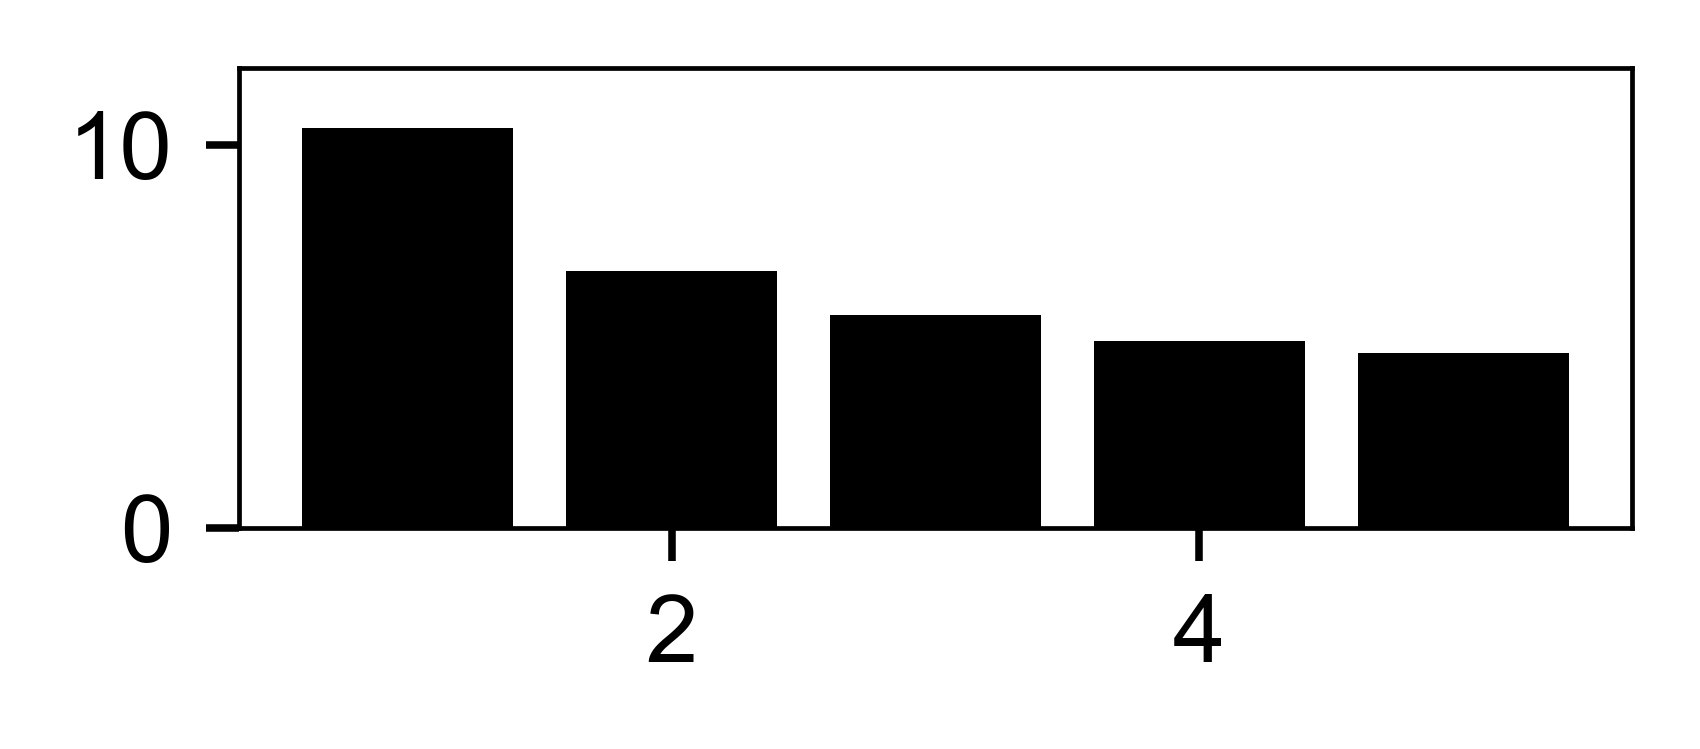

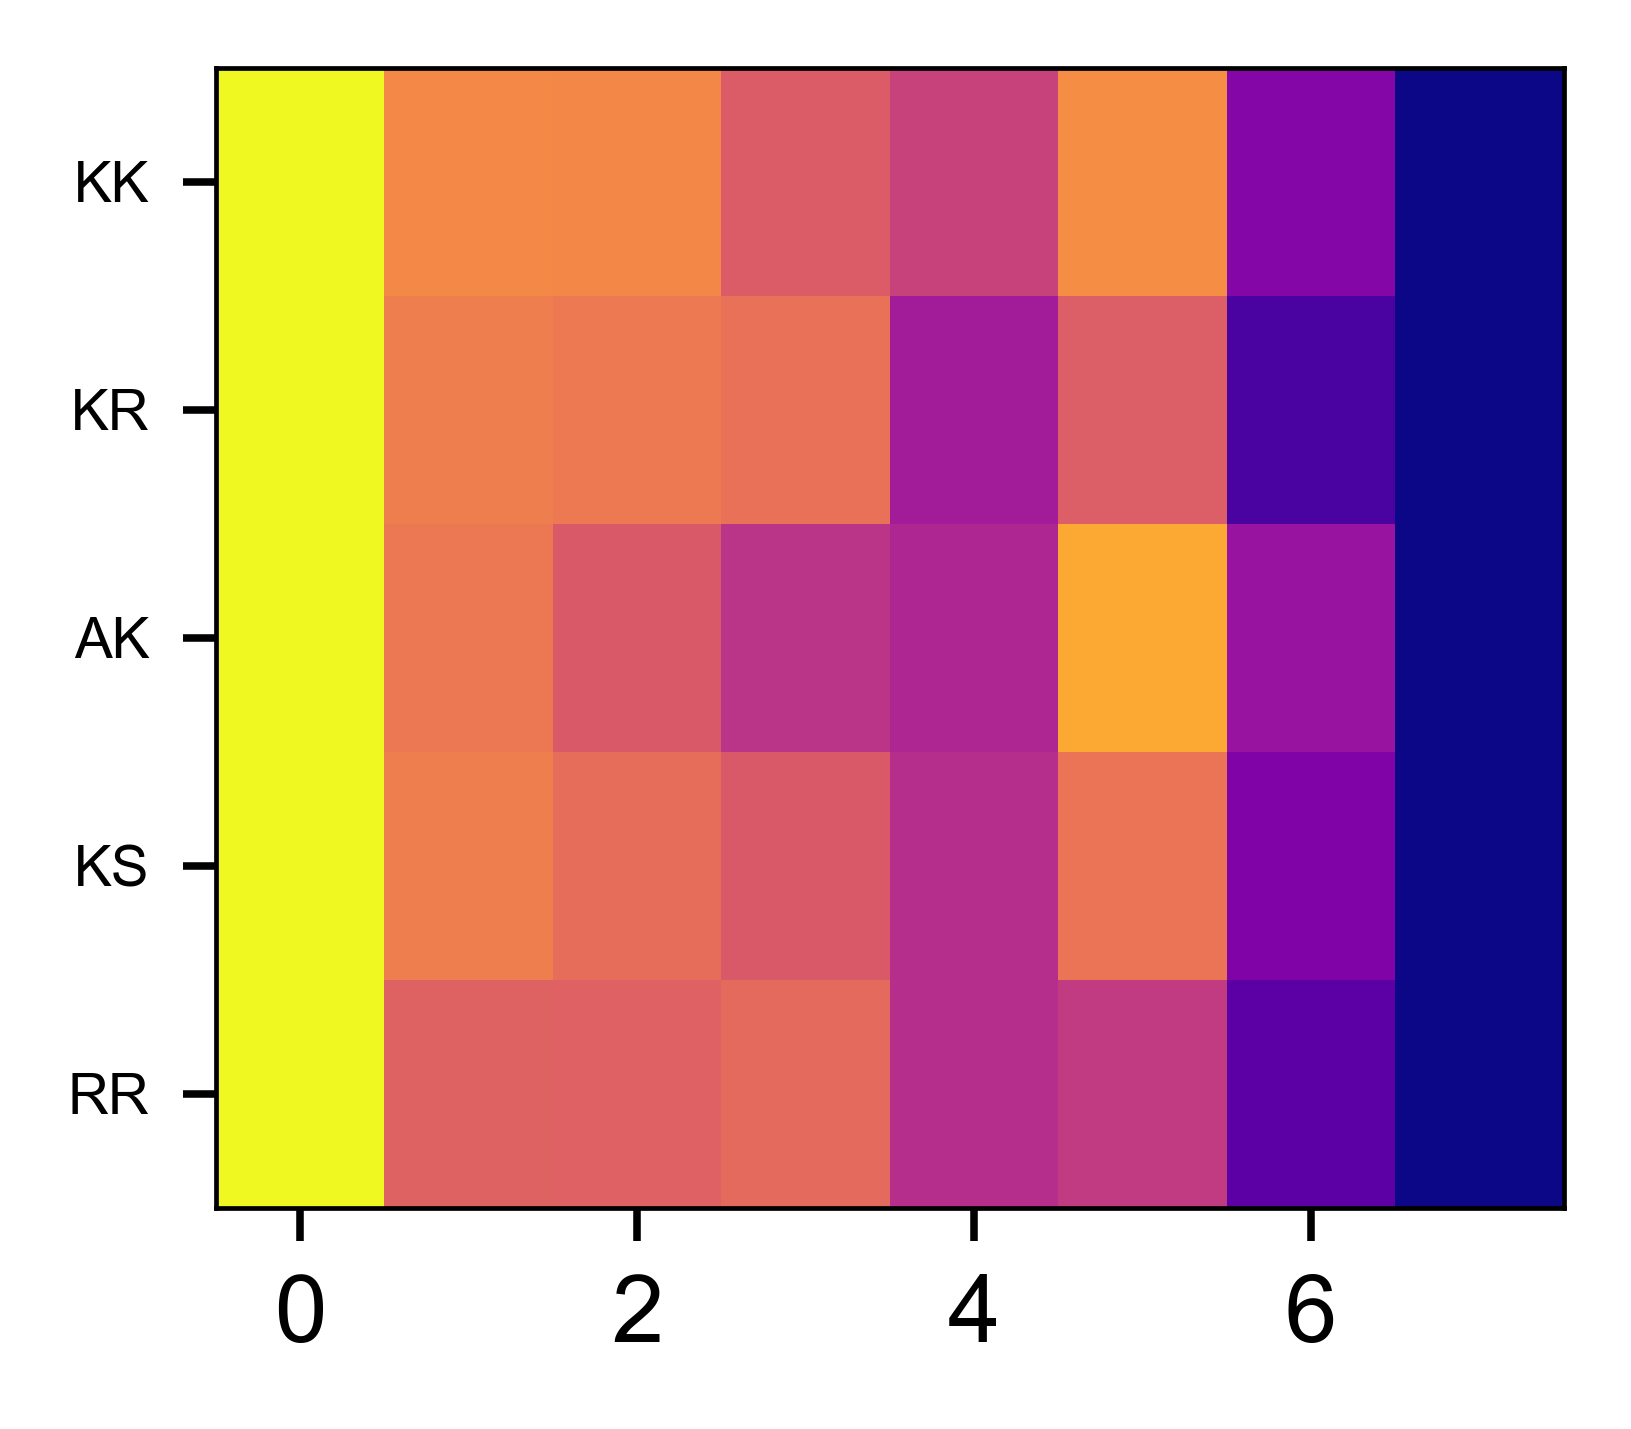

In [22]:
figure(None, (2.6,1.2), dpi=340)
local_vals = list(max_change_repulsive_strengthened.values())
local_idx  = np.arange(1, len(local_vals)+1)
plt.bar(local_idx, local_vals, color='k')
plt.ylim([0, params[domain_mode]['y-barlim']]) # define max so we have consist y axis for different chemistries 
plt.tight_layout()
plt.savefig(f'outfigures/{domain_mode}/{domain_mode}_repulsive_strengthen_interaction_magnitude.pdf')

figure(None, (2.5,2.2), dpi=340)

plt.imshow(np.array(repulsive_matrix_strengthed), cmap='plasma', aspect='auto')        
plt.yticks(np.arange(0,len(repulsive_matrix_names_strengthed)), repulsive_matrix_names_strengthed, fontsize=6)
print('')
print(f"Number of chemistries: {len(repulsive_matrix_names_strengthed)}")
#plt.colorbar()
plt.tight_layout()
plt.savefig(f'outfigures/{domain_mode}/{domain_mode}_repulsive_strengthen.pdf')


## Final cells
Finally, we show ALL attractive and repulsive interactions on the same plots, just for completeness

In [23]:
# build datasets for 
repulsive_matrix_all_vals = []
for name in repulsive_names_derivative_order:
    repulsive_matrix_all_vals.append(normalize_array(chem2mean_scores[name]))

attractive_matrix_all_vals = []
for name in attractive_names_derivative_order:
    attractive_matrix_all_vals.append(normalize_array(chem2mean_scores[name]))

/var/folders/2n/xtzsyspd32v6vglg_pd5gmw80000gn/T/ipykernel_4427/359662646.py:9: RuntimeWarning: invalid value encountered in divide
  normalized_arr = (arr - min_val) / (max_val - min_val)


## Plotting correlation between quantile and chemistry change
Finally, we can convince ourselves there is a clear relationship between folded domain surface chemistry and quantile by plotting the correlation coefficients obtained between quantile and chemistry for each of our peptide.

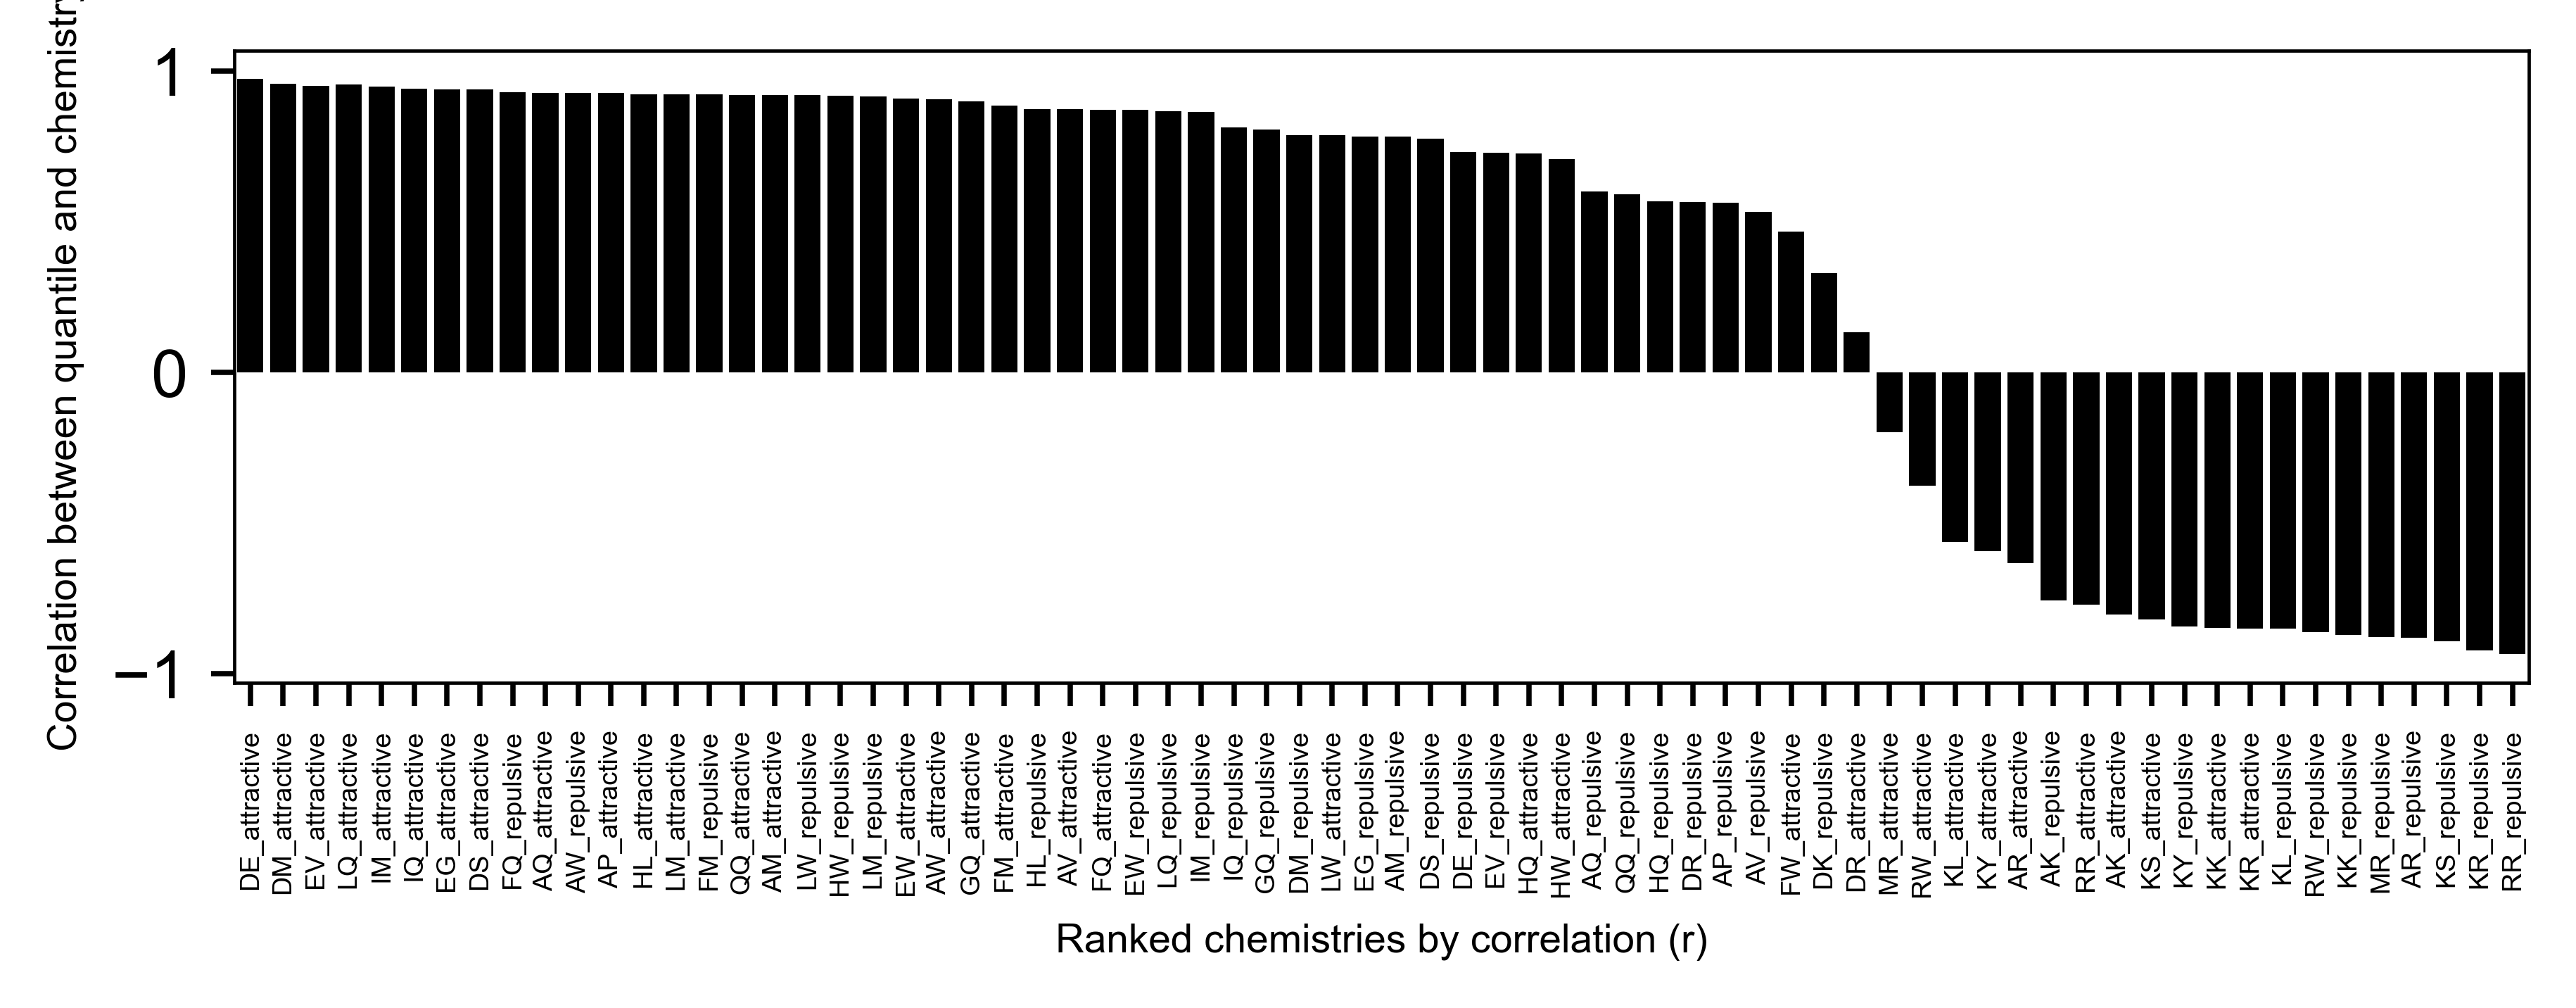

In [24]:

# sort and then remove the NaNs
## NB we have some NaNs because we use the median and for some chemistries ALL the medians are 0 with either 
# repulsive or attractive chemistries, meaning our correlation (and derivative) is NaN
sorted_dict_desc = dict(sorted(chem2cor.items(), key=lambda item: item[1], reverse=True))

local_vals = []
local_names = []
for k in sorted_dict_desc:
    v = sorted_dict_desc[k]
    if ~np.isnan(v):
        local_vals.append(v)
        local_names.append(k)
        
figure(None, (5.6,2.2), dpi=340)
ax = plt.gca()

plt.bar(np.arange(1,len(local_vals)+1), local_vals, color='k')


plt.ylabel('Correlation between quantile and chemistry', fontsize=6)
plt.xlabel('Ranked chemistries by correlation (r)', fontsize=6)
plt.xticks(np.arange(1,len(local_vals)+1), local_names, rotation=90, fontsize=4)
plt.xlim([0.5,70.5])
plt.tight_layout()
plt.savefig(f'outfigures/{domain_mode}/all_correlations_quant_vs_chem.pdf')


## Plotting derivatives of chemical interactions vs. quantile
This sounds complicated but it's not. The plots here are saying "if we looked at the linear correlation between quantile (x-axis) and average chemical interaction for domains of proteins associated with each quantile (y-axis) what is the gradient of that straight line. 

The reason to do this is that the correlation coefficients above capture the TRENDS but not the magnitude, whereas the derivative gives you magnitude information as well

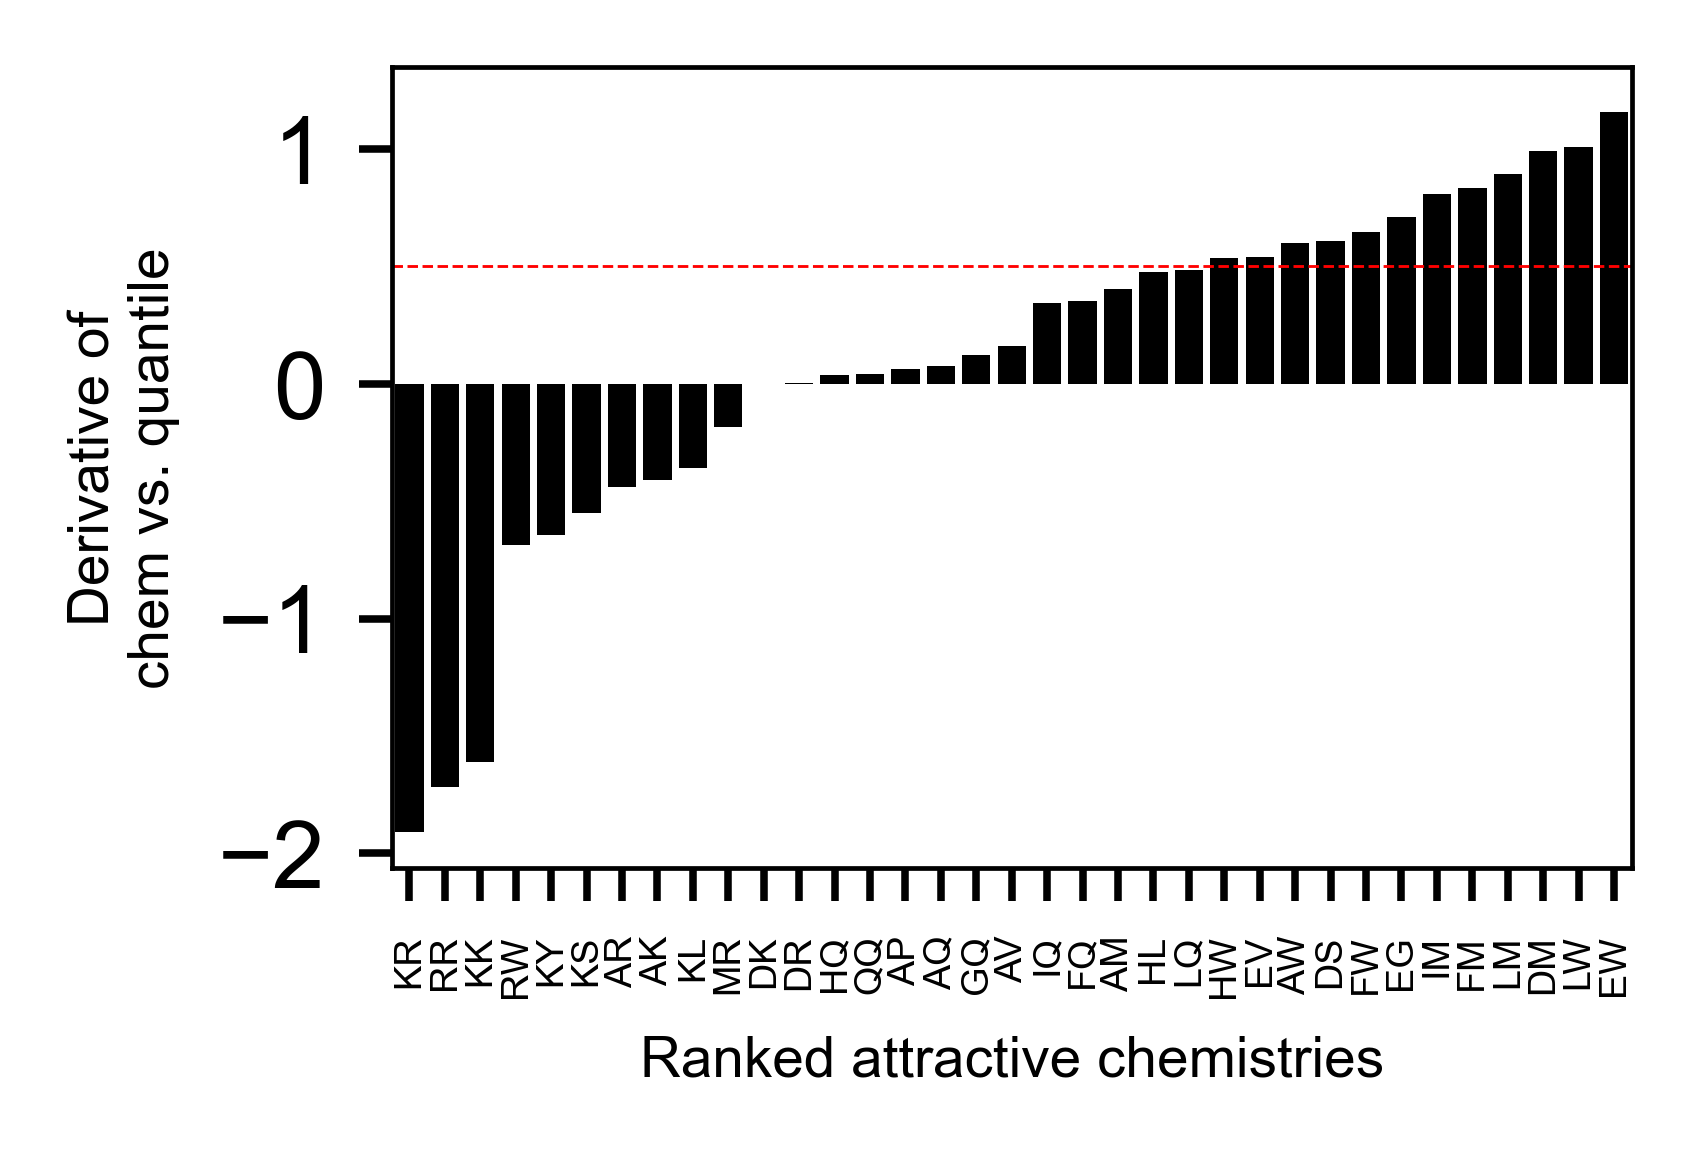

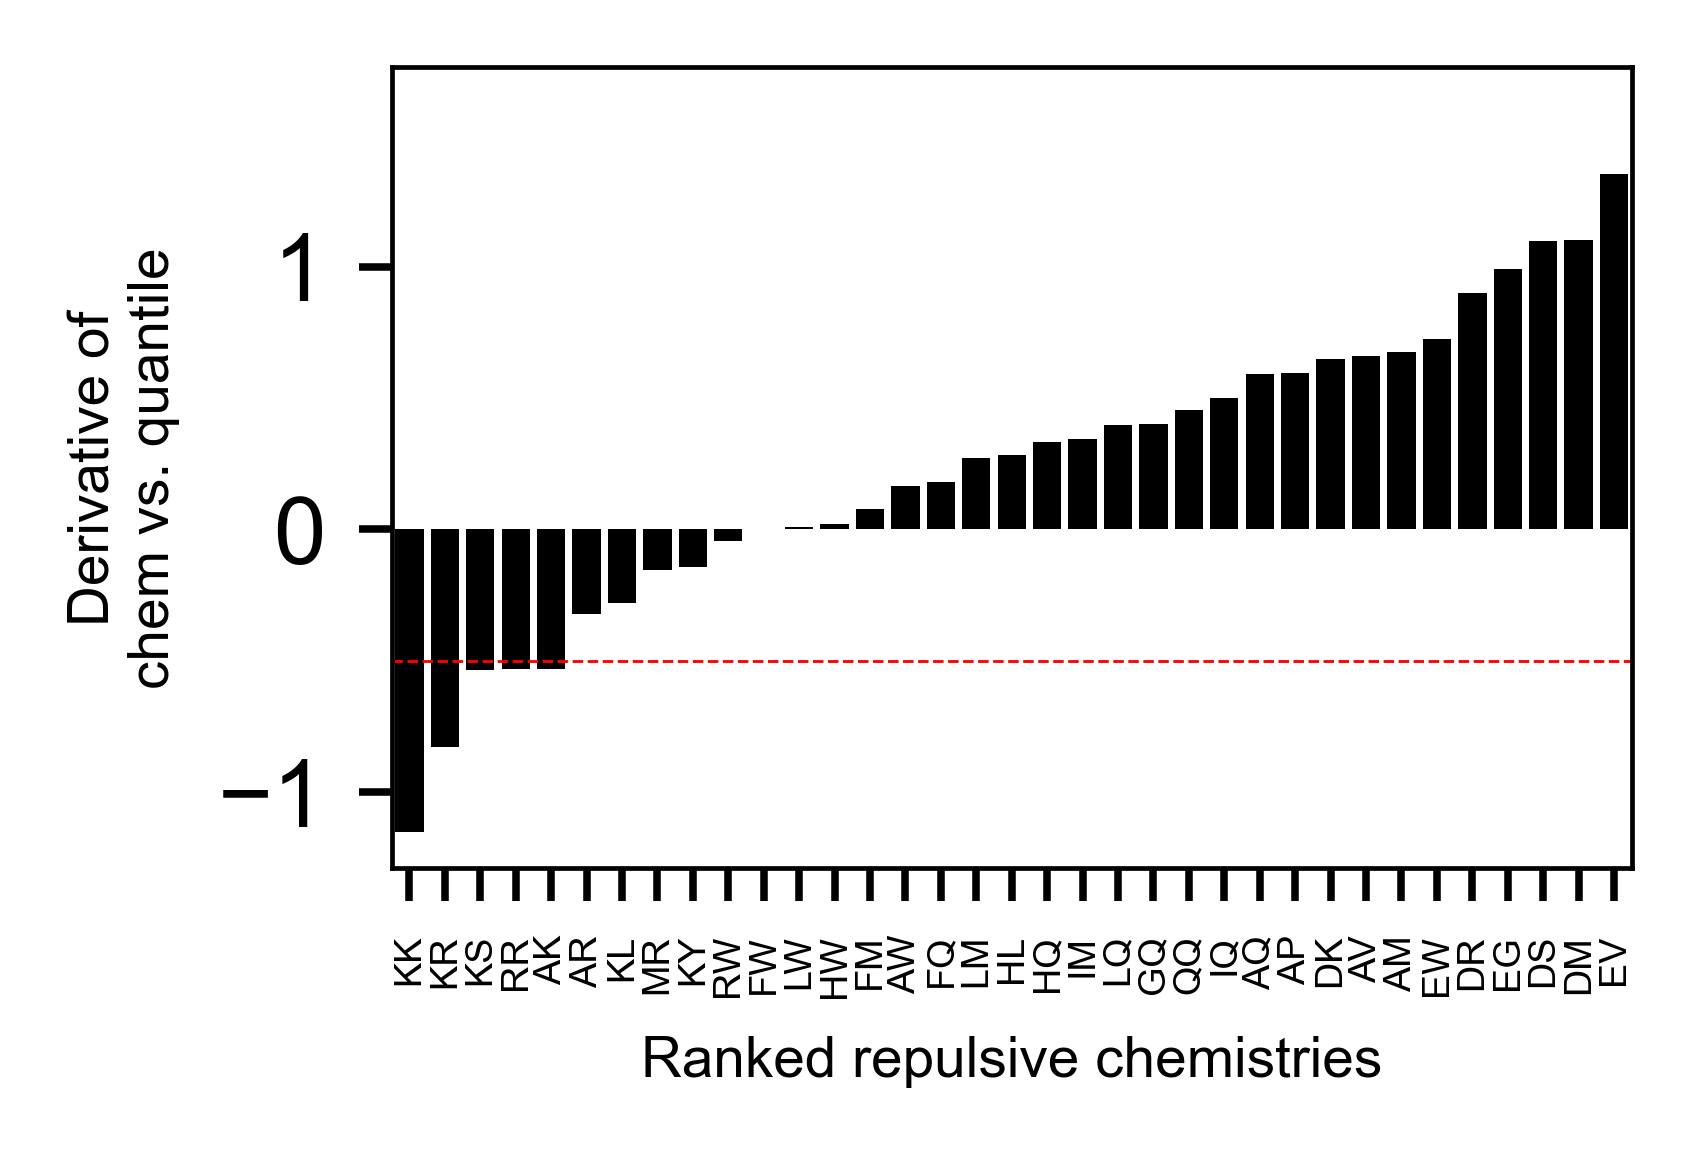

In [25]:
figure(None, (2.6,1.8), dpi=340)
ax = plt.gca()

threshold = params[domain_mode]['attractive_derivative']
plt.bar(np.arange(1,len(all_attractive_linear_fit_gradients)+1), all_attractive_linear_fit_gradients, color='k', lw=0.5)
plt.ylabel('Derivative of\nchem vs. quantile', fontsize=6)
plt.xlabel('Ranked attractive chemistries', fontsize=6)
plt.xticks(np.arange(1,len(all_attractive_linear_fit_gradients)+1), [i.split('_')[0] for i in attractive_names_derivative_order], rotation=90, fontsize=4)
ax.axhline(threshold,color='r',ls='--',lw=0.3)
plt.xlim([0.5,35.5])
plt.tight_layout()
plt.savefig(f'outfigures/{domain_mode}/derivative_chem_vs_quant_attractive.pdf')


figure(None, (2.6,1.8), dpi=340)
ax = plt.gca()

threshold = params[domain_mode]['repulsive_derivative']
plt.bar(np.arange(1,len(all_repulsive_linear_fit_gradients)+1), all_repulsive_linear_fit_gradients, color='k', lw=0.5)
plt.ylabel('Derivative of\nchem vs. quantile', fontsize=6)
plt.xlabel('Ranked repulsive chemistries', fontsize=6)
plt.xticks(np.arange(1,len(all_repulsive_linear_fit_gradients)+1), [i.split('_')[0] for i in repulsive_names_derivative_order], rotation=90, fontsize=4)
ax.axhline(threshold,color='r',ls='--',lw=0.3)
plt.xlim([0.5,35.5])
plt.tight_layout()
plt.savefig(f'outfigures/{domain_mode}/derivative_chem_vs_quant_repulsive.pdf')

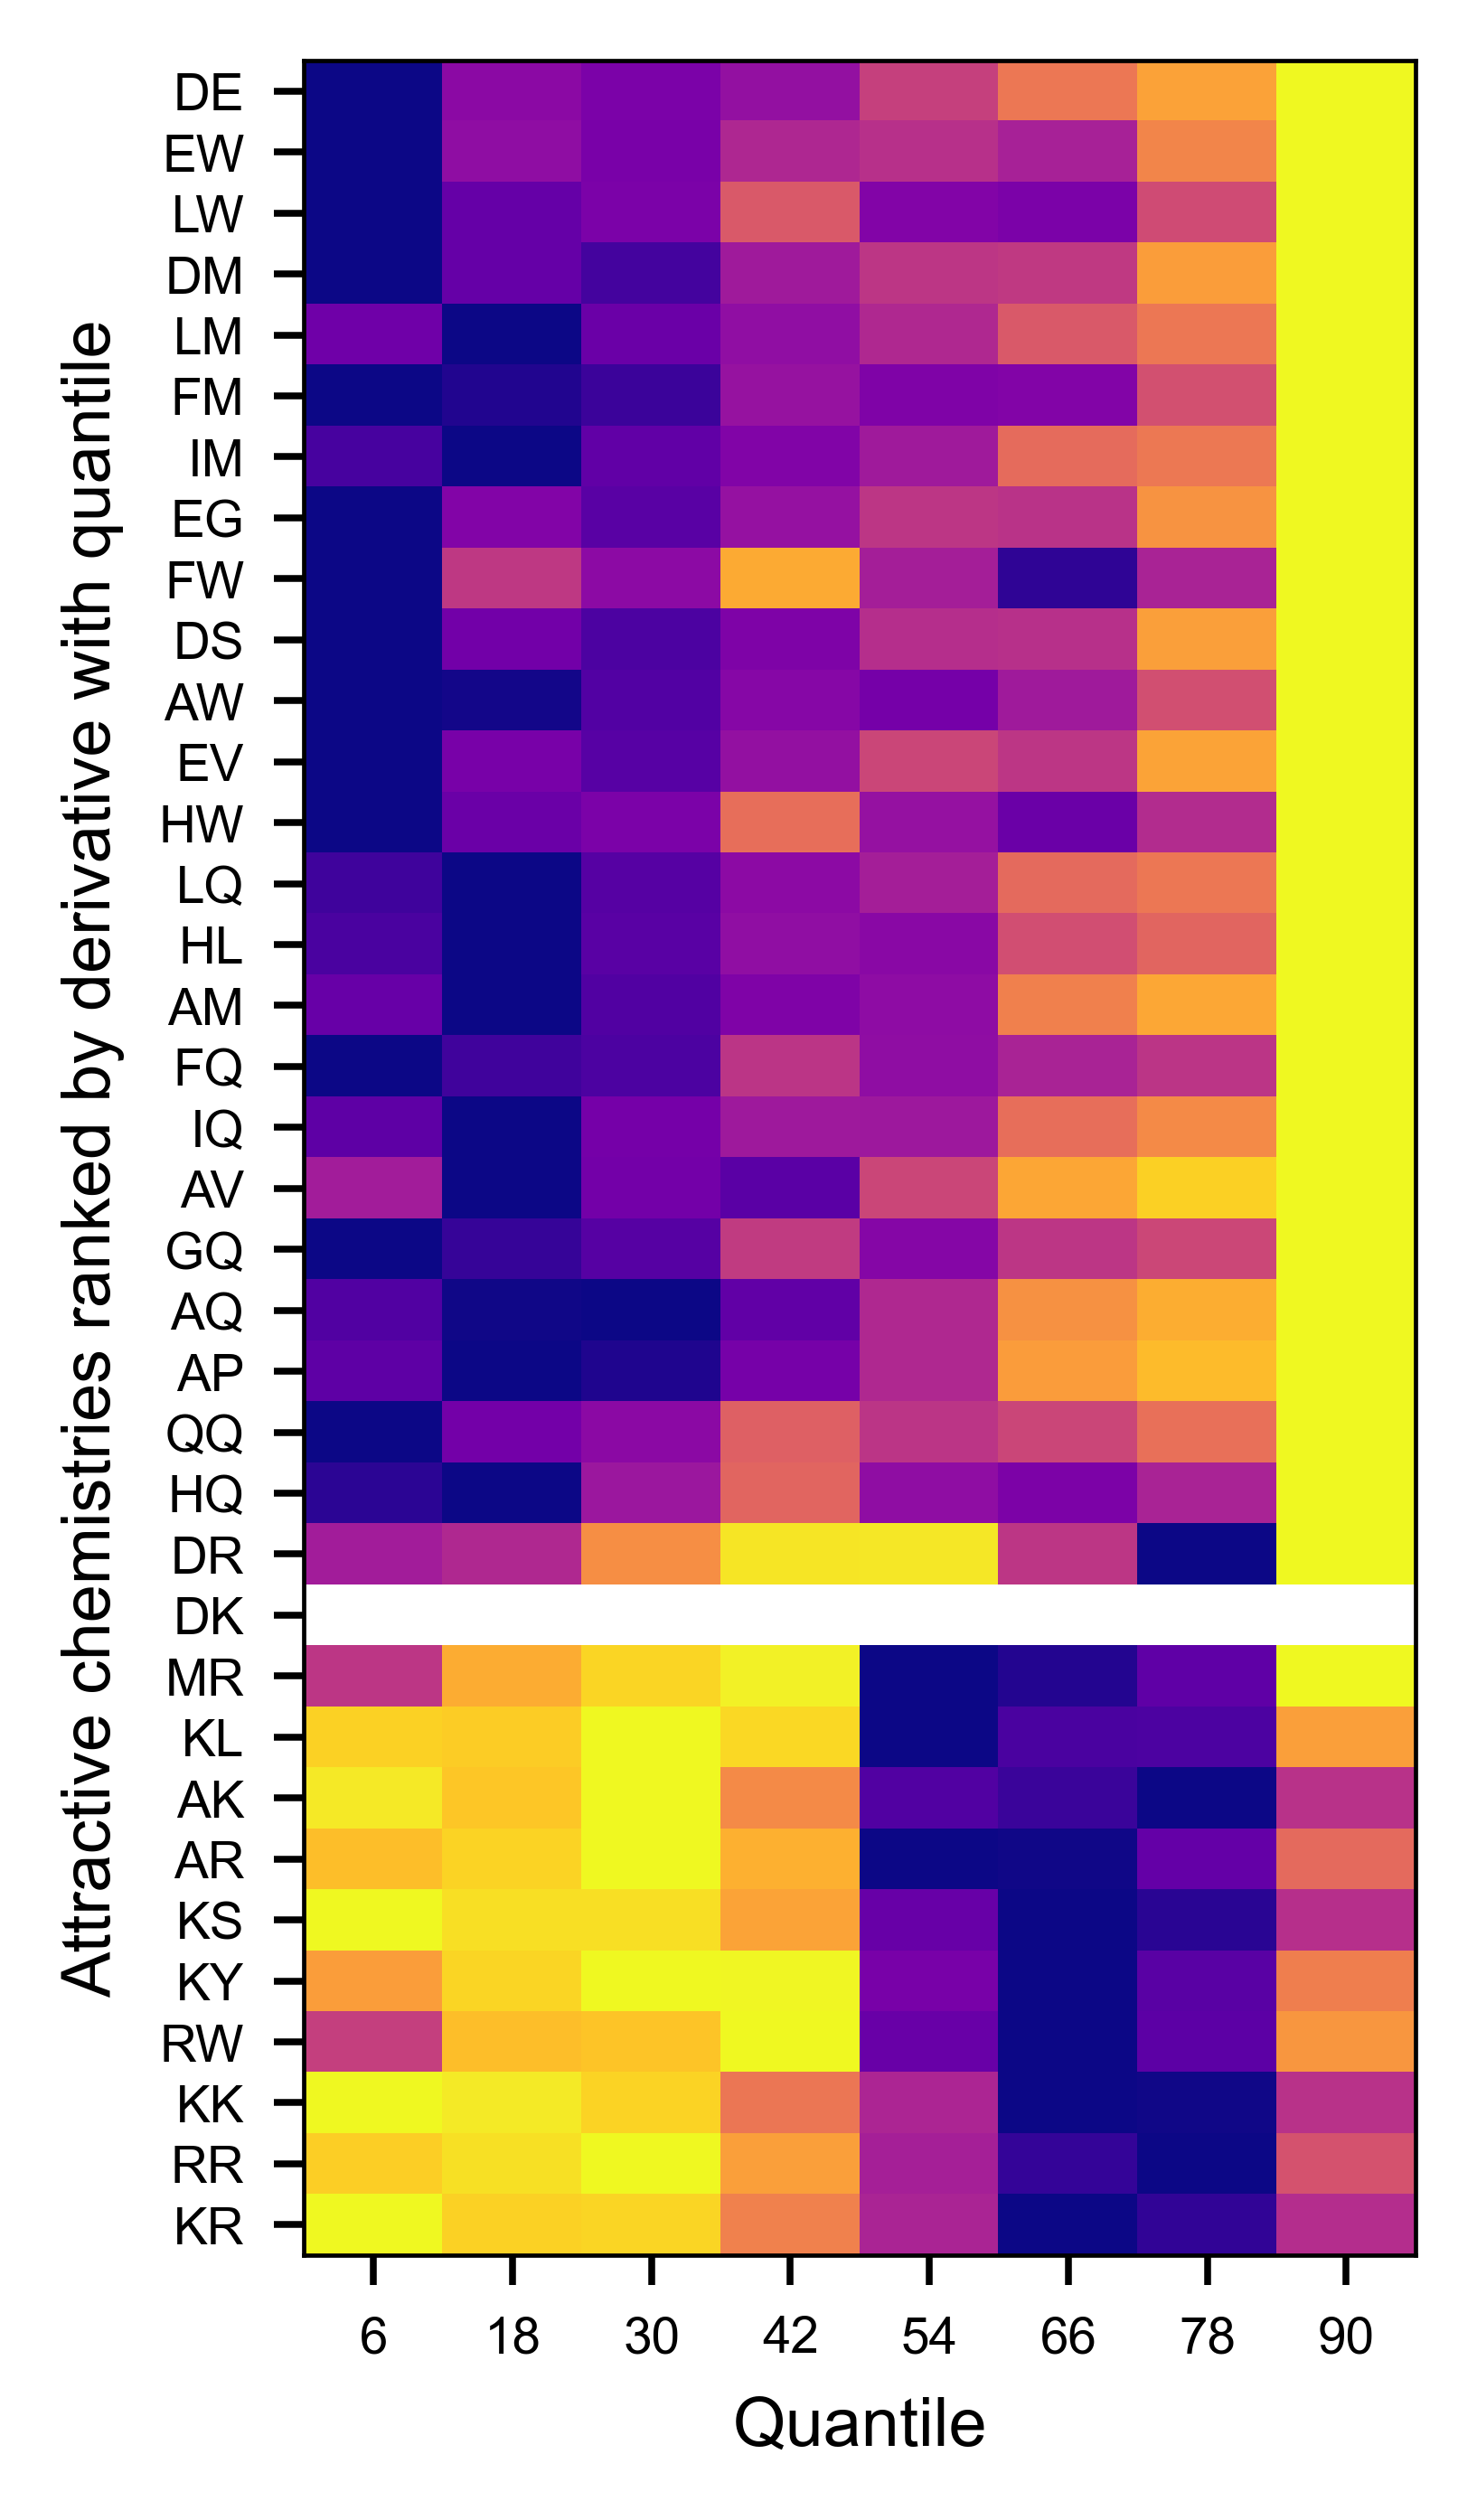

In [26]:
figure(None, (2.5,4.2), dpi=340)
plt.imshow(np.array(attractive_matrix_all_vals[::-1]), cmap='plasma', aspect='auto')        
plt.yticks(np.arange(0,len(attractive_names_derivative_order)), [i.split('_')[0] for i in attractive_names_derivative_order[::-1]], fontsize=6)
print('')
plt.tight_layout()
plt.savefig(f'outfigures/{domain_mode}/{domain_mode}_attractive_all_heatmap.pdf')
plt.ylabel('Attractive chemistries ranked by derivative with quantile', fontsize=8)
plt.xlabel('Quantile', fontsize=8)
plt.xticks(np.arange(0,8), REFERENCE_QUANTILES, fontsize=6)

plt.tight_layout()
plt.savefig(f'outfigures/{domain_mode}/all_attractive_heatmap.pdf')

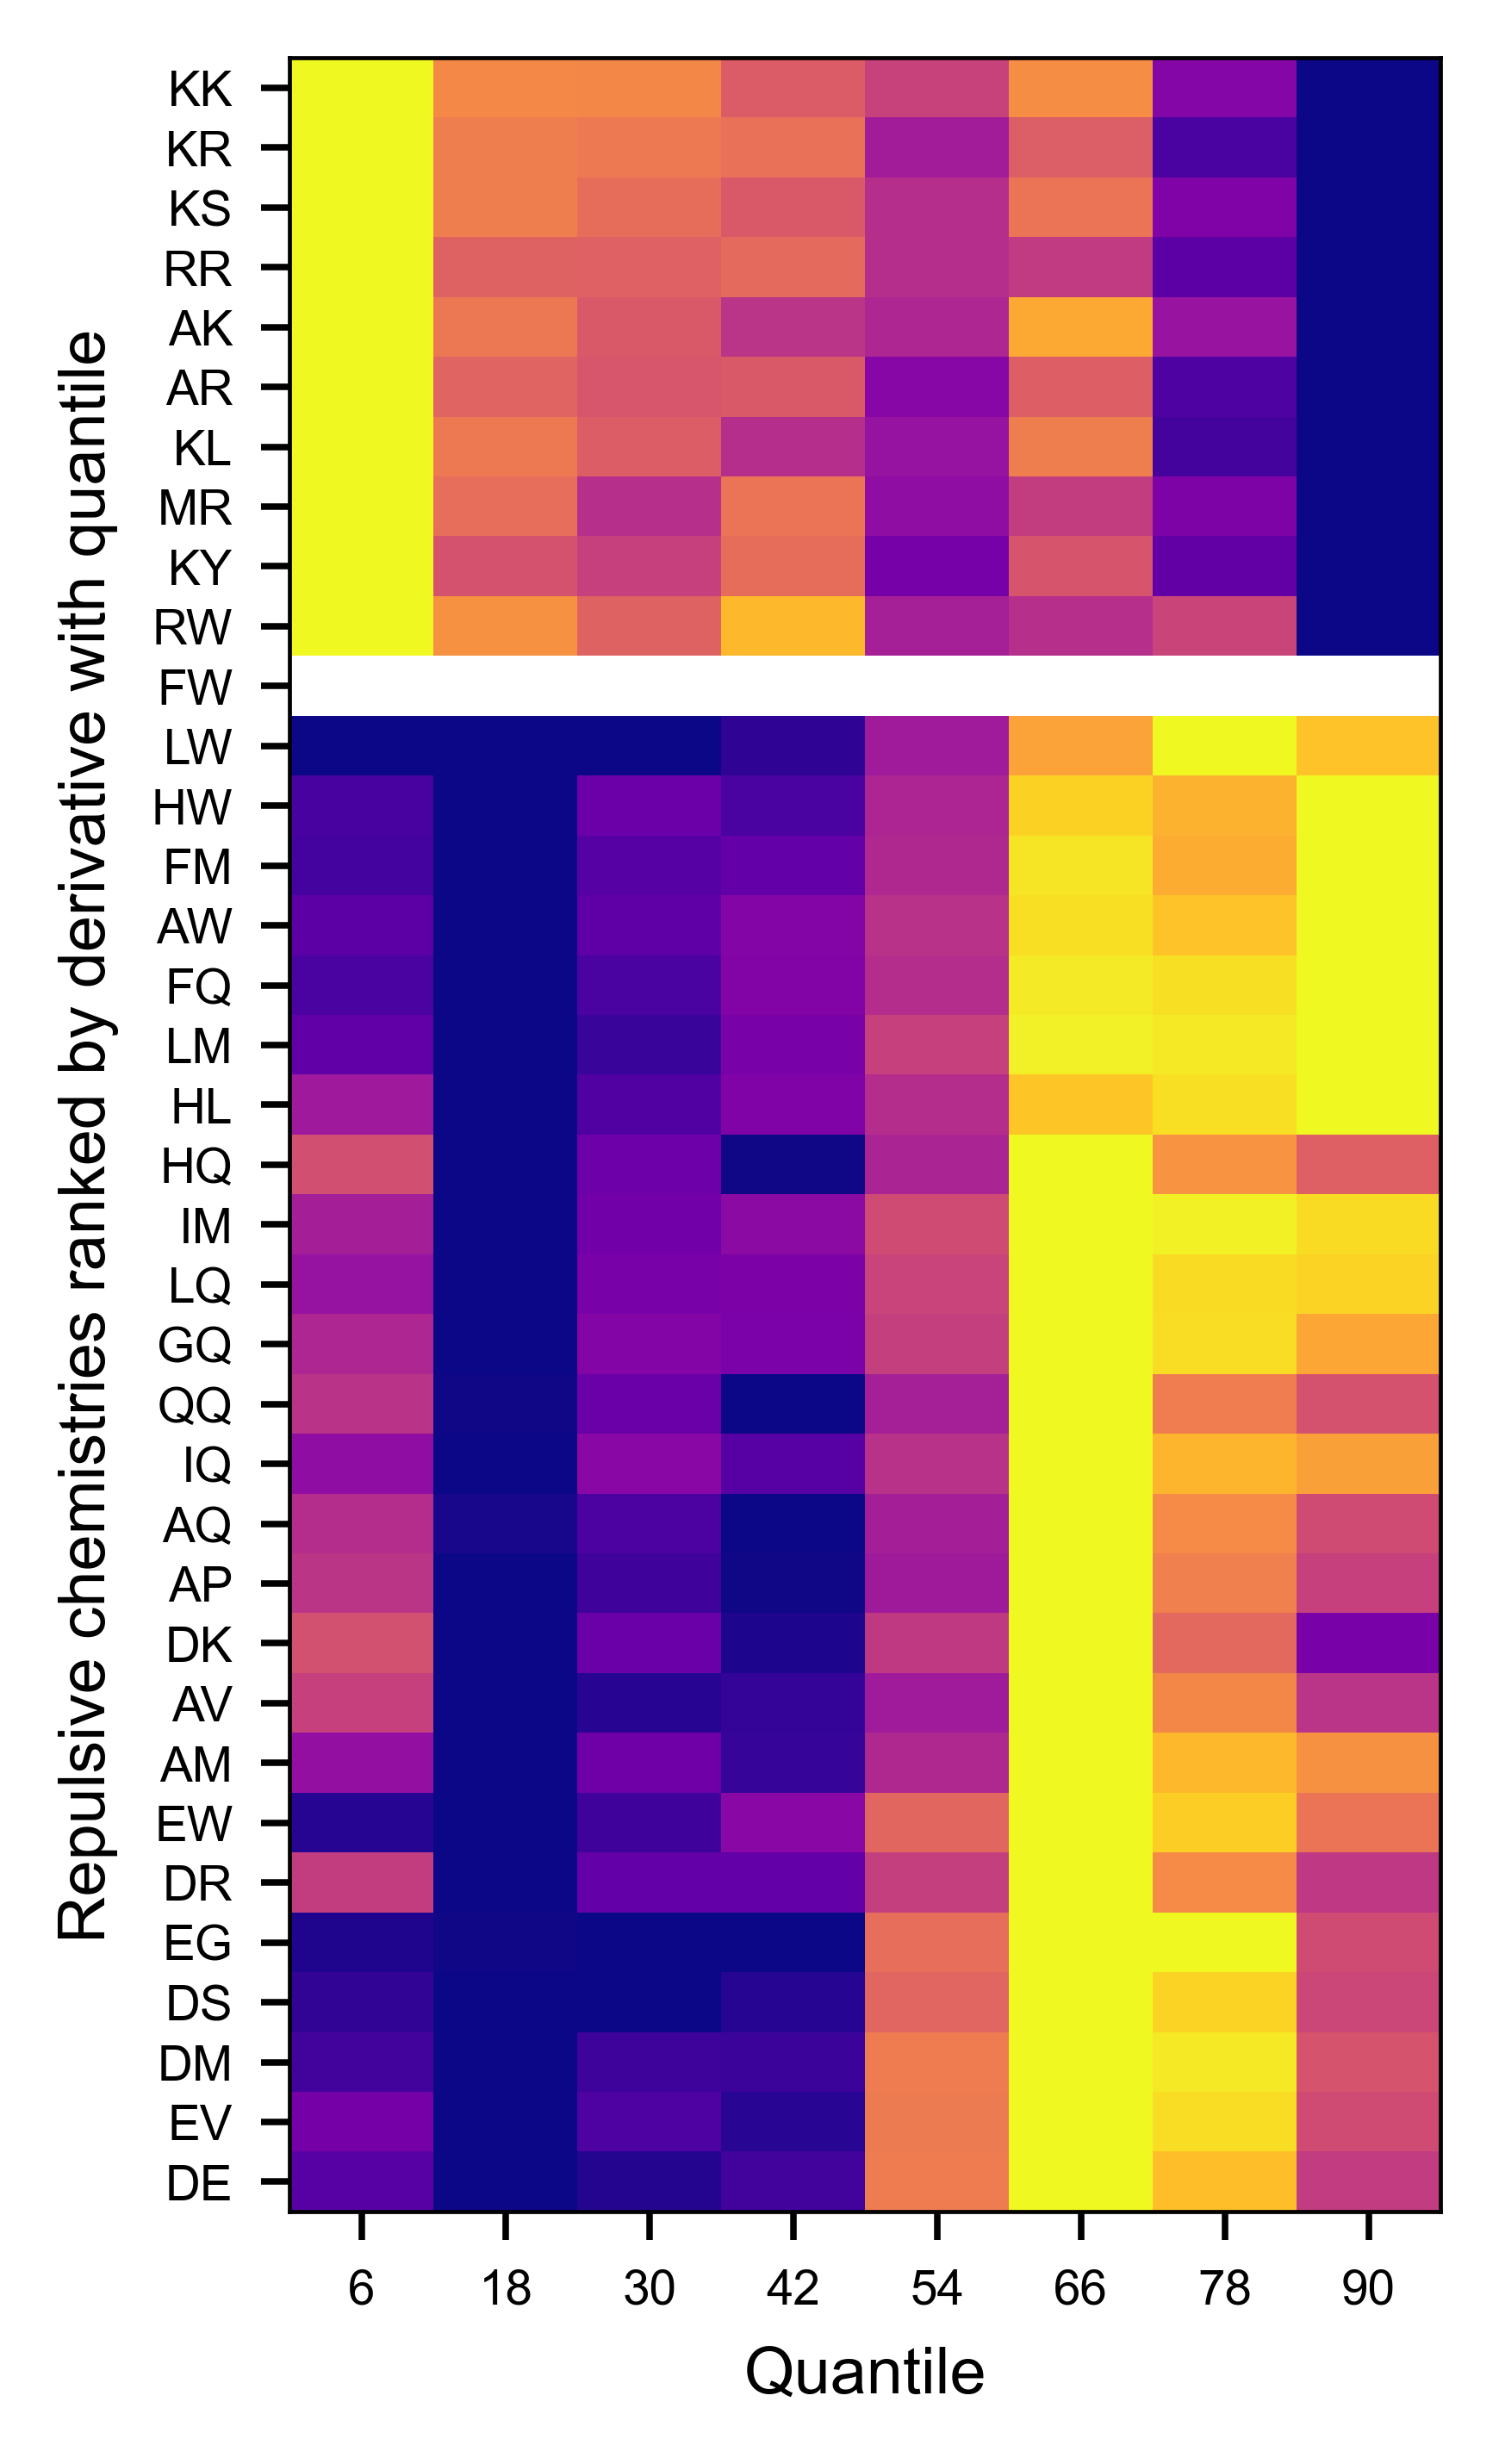

In [27]:
figure(None, (2.5,4.2), dpi=340)
plt.imshow(np.array(repulsive_matrix_all_vals), cmap='plasma', aspect='auto')        
plt.yticks(np.arange(0,len(repulsive_names_derivative_order)), [i.split('_')[0] for i in repulsive_names_derivative_order], fontsize=6)
print('')
plt.tight_layout()
plt.savefig(f'outfigures/{domain_mode}/{domain_mode}_repulsive_all_heatmap.pdf')
plt.ylabel('Repulsive chemistries ranked by derivative with quantile', fontsize=8)
plt.xlabel('Quantile', fontsize=8)
plt.xticks(np.arange(0,8), REFERENCE_QUANTILES, fontsize=6)
plt.savefig(f'outfigures/{domain_mode}/all_repulsive_heatmap.pdf')